# Overview of exercises:
1. Exploring with morphological operators (dilation, erosion, opening, closing, gradient, etc.). Using simple median / Gaussian filters, and using local thresholding for uneven background illumination
2. 'Analyze particles' functionality in Python for nucleus sizes / cell sizes. Comparison with the same process in FIJI.
    - This is a standard example online and a good thing for everyone to get through
3. Making a kymograph in Python. Making one in a better/easier/automatic manner in FIJI.
4. 3D watershed to reconstruct volume through pixel-counting (fully in Python). Instructions for doing the same in FIJI if time.

There are a few sections labeled '**Go further**' that suggest extensions to the main exercises. Please only spend time on these if you've finished everything else.

In [ ]:
# Connect to Google drive to access required data and images
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import a bunch of libraries that will be useful for these exercises
%pip install wheel
%pip install plotly==5.4.0

import numpy as np
import cv2 # OpenCV, a library of computer vision tools - NOT included just by using Jupyter, but IS in Google Colab
import imutils # Helpful functions for image processing - NOT included just by using Jupyter, but IS in Google Colab
import matplotlib.pyplot as plt
import matplotlib.animation as animation # To play a movie
import plotly # Convenient plotting functions, helpful for working with 3D data
import plotly.express as px
from skimage import measure # Several functions for image processing
from skimage import restoration as res # Contains a background-subtraction method we'll use briefly
import time # For timing execution of blocks of code
from skimage.morphology import watershed # Segmentation algorithm

%matplotlib inline
# To make displays nicer. Note: This causes FuncAnimation videos to fail to display in notebook

     |████████████████████████████████| 25.3 MB 1.6 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


## Exercise set #1 - Introduction to morphological operations (binary images)

This exercise set includes:
- Applying a basic threshold to an image to generate a mask (basically, separate foreground from background)
- Applying dilations, erosions, openings, and closings to this mask. Before running the code, predict how the result will look.
- Repeating the thresholding step, but do some preprocessing on the image beforehand to try to get a cleaner mask. Use one or more of these morphological operations to get a mask that usefully picks out relevant objects.

Good reference (a Medium blog post) on morphological operations on grayscale images (instead of binary, like we're using here). The idea is exactly the same, but there are 256 possible values instead of 2:
https://himnickson.medium.com/morphological-operations-in-image-processing-cb8045b98fcc

### Step one - read in a test image. We'll use a default one from Python

In [1]:
from skimage import data
img = data.coins() # Grayscale image of some coins
plt.imshow(img,cmap='gray')
plt.show()

NameError: ignored

In [ ]:
# Get basic information about the image. In reality, this would be known, especially if you acquired the data yourself
print(np.shape(img)) # Image size (height x width - Numpy uses x as the number of rows and y as number of columns)
print(np.dtype(img[1,1])) # Bit depth / data type

(303, 384)
uint8


### Step two - threshold the image to produce a mask. We'll use Otsu's method

In [ ]:
# Make a better mask using some preprocessing
meanBlur = cv2.blur(img,(5,5))
gaussBlur = cv2.GaussianBlur(img,(5,5),0) # Automatically computes sigma, but you can set manually if preferred
medBlur = cv2.medianBlur(img,5)

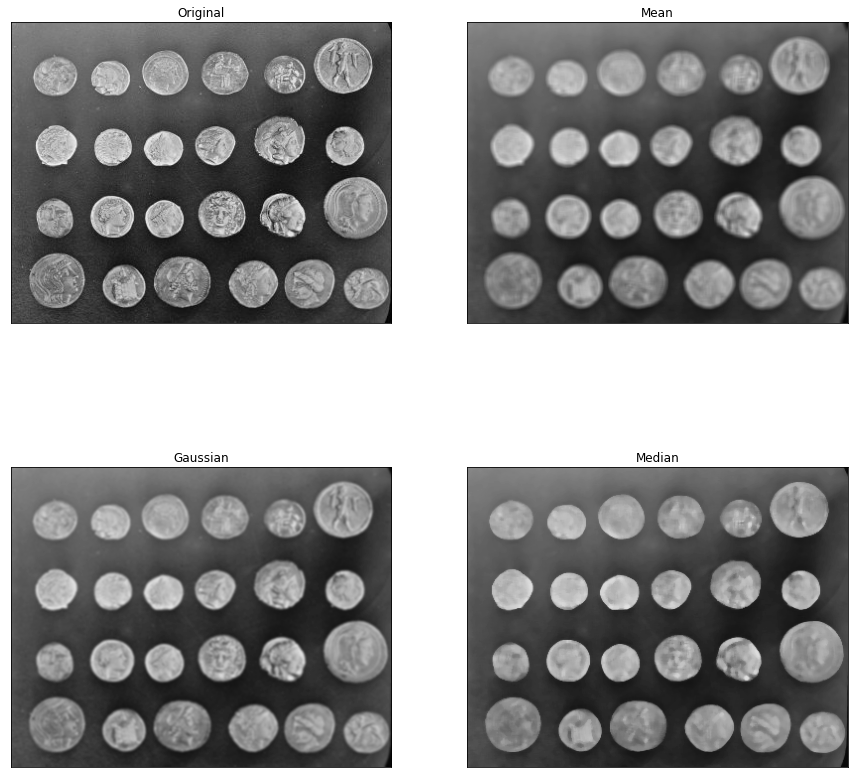

In [ ]:
images = [img, meanBlur, gaussBlur, medBlur]
titles = ['Original', 'Mean', 'Gaussian', 'Median']
plt.rcParams['figure.figsize'] = [15, 15] # See if this can be automated to fit screen size (or if it already is)
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

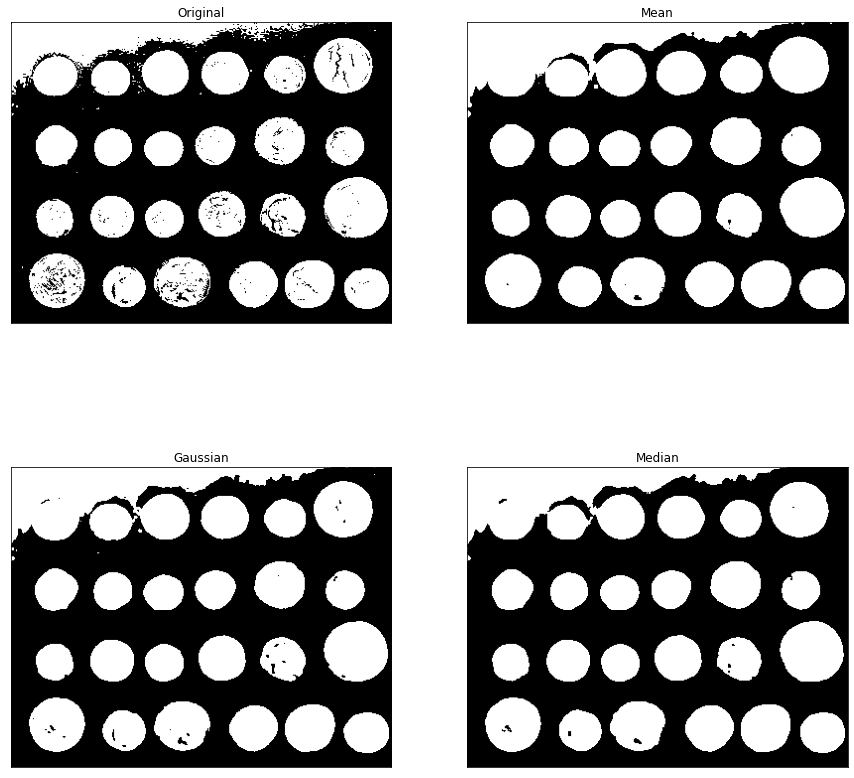

In [ ]:
# Threshold coin image to produce binary image - use Otsu's method to automatically set threshold
thresh, imgBin = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Returns threshold, then mask
meanthresh, meanBin = cv2.threshold(meanBlur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
gaussthresh, gaussBin = cv2.threshold(gaussBlur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
medthresh, medBin = cv2.threshold(medBlur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

images = [imgBin, meanBin, gaussBin, medBin]
titles = ['Original', 'Mean', 'Gaussian', 'Median']
plt.rcParams['figure.figsize'] = [15, 15] # See if this can be automated to fit screen size (or if it already is)
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### Step three - create a kernel and perform operations

In [ ]:
# Create some 'kernels' for morphological operations
squareKern = np.ones((5,5),np.uint8) # Square
ellipseKern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) # Slightly asymmetric, but nearly a circle
crossKern = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))

In [ ]:
kernel = squareKern
image = medBin

# Dilation - 'make it fatter'
dil = cv2.dilate(image,kernel,iterations = 1)
# Erosion - 'make it thinner'
ero = cv2.erode(image,kernel,iterations = 1)
# Opening - erosion followed by dilation - note the different syntax
ope = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
# Closing - dilation followed by erosion
clo = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
# Gradient
gra = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
# Top hat
tHat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
# Black hat
bHat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)

### Step four - display results

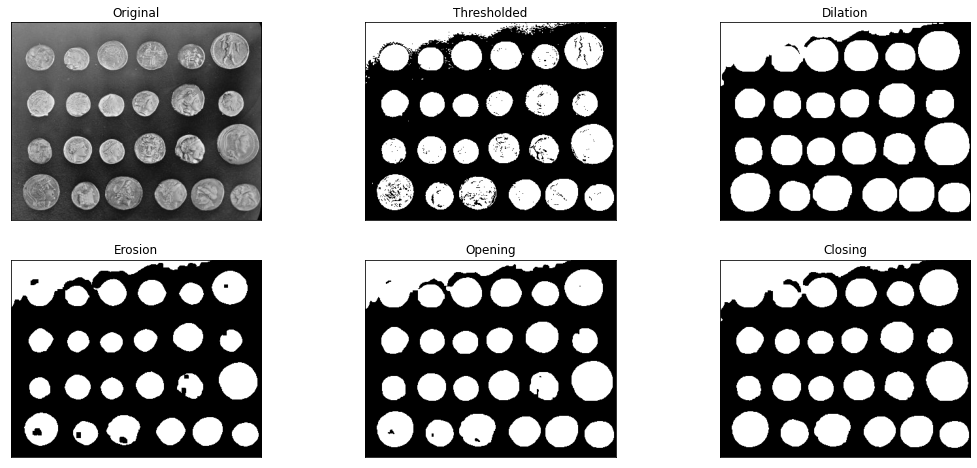

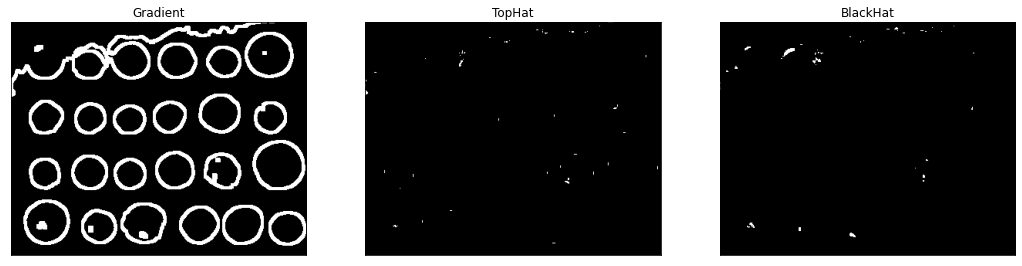

In [ ]:
# View results
plt.rcParams['figure.figsize'] = [18, 8] # May have to adjust these for different screen sizes
images = [img, imgBin, dil,
          ero, ope, clo,
          gra, tHat, bHat]
titles = ['Original', 'Thresholded', 'Dilation',
          'Erosion', 'Opening', 'Closing',
          'Gradient', 'TopHat', 'BlackHat']
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()
for i in range(6,9): # Split off for formatting (3x3 grid gives small images). There's surely a better way to do it
    plt.subplot(1,3,i-5),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### Step five - make better masks using two other methods

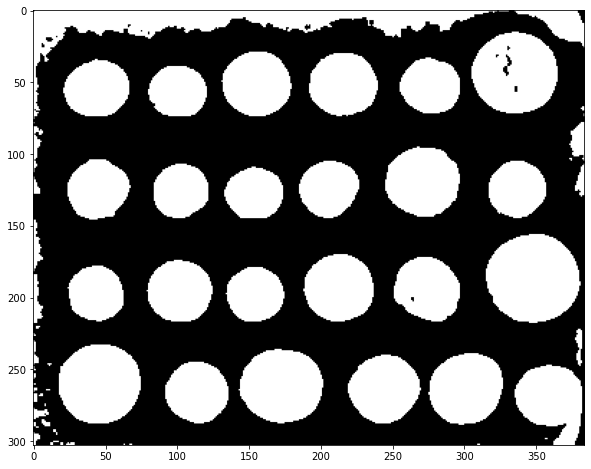

In [ ]:
# Do a better threshold: Gaussian blur + local thresholding
gaussBlur = cv2.GaussianBlur(img,(5,5),0)
thresh = cv2.adaptiveThreshold(gaussBlur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 151, 4)
    # Image, threshold, style, invert, kernel size, tuning factor
plt.imshow(thresh,'gray')
plt.show()

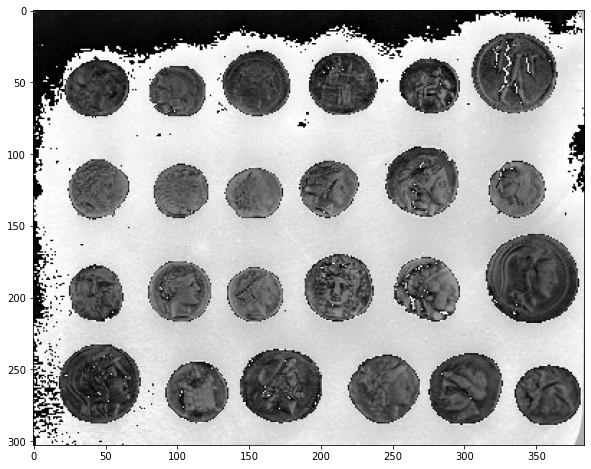

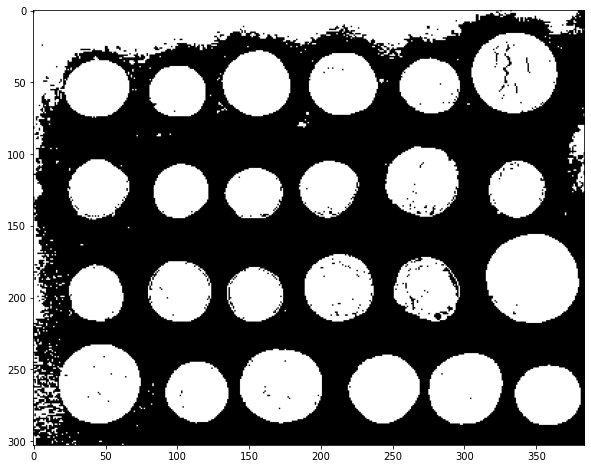

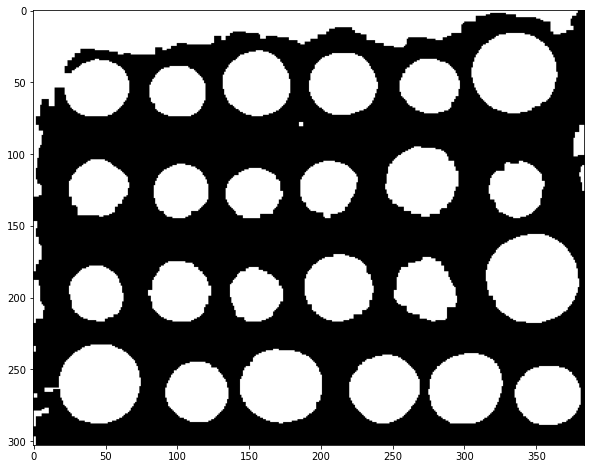

In [ ]:
# Another improved way: background subtraction + morphological opening/closing
cleaned = img - cv2.GaussianBlur(img,(201,201),0)
plt.imshow(cleaned,'gray')
plt.show()
thresh2, imgBin2 = cv2.threshold(cleaned,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(255-imgBin2,'gray') # Ended up inverted; not sure why right now
plt.show()
openKern = np.ones((3,3),np.uint8)
closeKern = np.ones((5,5),np.uint8)
ope2 = cv2.morphologyEx(cv2.morphologyEx(255-imgBin2, cv2.MORPH_OPEN, openKern), cv2.MORPH_CLOSE, closeKern)
plt.imshow(ope2,'gray')
plt.show()

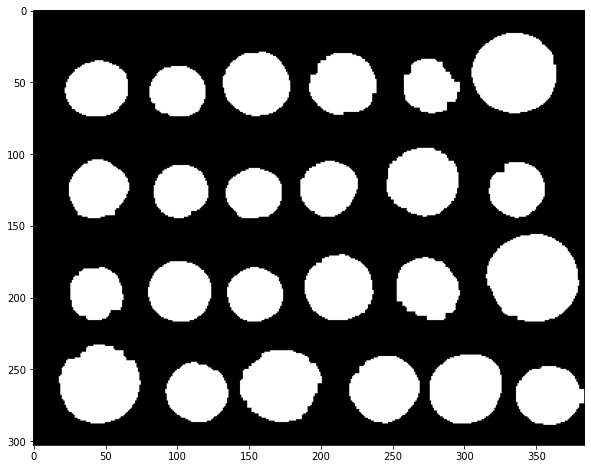

In [ ]:
# Fixing the uint8 weirdness (e.g. 4 - 6 = -2, but with uint8 it's 256 + (4 - 6) = 254 because it rolls around)
cleaned16 = (img.astype(np.int16) - cv2.blur(img,(251,251)).astype(np.int16)) # Cast to 16-bit to allow negatives
cleaned16_shift = cleaned16 - np.min(cleaned16) # Subtract out minimum (this is necessary to shift to [0, 255] range later)
cleaned8 = cleaned16_shift.astype('uint8') # Cast back to unsigned 8-bit integer (Python's image type)
thresh3, imgBin3 = cv2.threshold(cleaned8,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Threshold
openKern = np.ones((3,3),np.uint8)
closeKern = np.ones((7,7),np.uint8)
ope3 = cv2.morphologyEx(cv2.morphologyEx(imgBin3, cv2.MORPH_OPEN, openKern), cv2.MORPH_CLOSE, closeKern)
plt.imshow(ope3,'gray')
plt.show()

**Go further** - write code to investigate and succinctly display the effects of changing kernel size on these outputs. Use a square kernel for ease, and choose a few different kernel sizes. Remember the image size when considering kernel sizes.

## Exercise set #2 - Make a kymograph to summarize a 3D movie in one 2D plot

This exercise includes:
- Reading in and working with a 3D image (x, y, time)
- Making a kymograph from the movie to visualize cell movement/growth - do this along the horizontal dimension
- Playing around with the line width used for the kymograph to see what happens

You'll be making a kymograph from data used in Imran Alsous et al. *PNAS* (2021). For biological context, below is a schematic of a fruit fly egg chamber, which is the sample included in the provided imaging data. It's not necessary to know this to make the kymograph, but it is helpful for interpreting the results.

A and P denote anterior and posterior directions. Fluid flows between cells from anterior to posterior, and the oocyte (Oo, gray) enlarges as the nurse cells (support cells, colored blue, red, green, or yellow here) tranport their contents to it and shrink. For convenience, these support cells can be grouped into 'layers' based on distance from the oocyte.

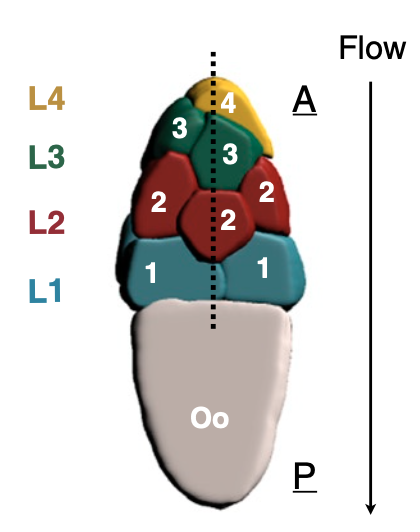

In [ ]:
# Useful information (from the imaging metadata)
dx = 0.8856 # Pixel spacing in x and y dimensions, in µm
dt = 15.19 # Time between frames of the movie, in seconds

In [ ]:
# Read in data
fname = '/content/gdrive/MyDrive/QMW_files/062419_sqhRFP_sfGFP_MIP_adjusted_sqhRFPonly_subsetInTime.tif'
ret, img2 = cv2.imreadmulti(fname, [], 0) # Image is the second output; the '0' argument means 'grayscale'
img2 = np.array(img2)
theshape = np.shape(img2) # (Time, height, width)
theshape

(458, 205, 377)


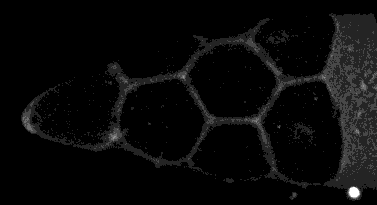
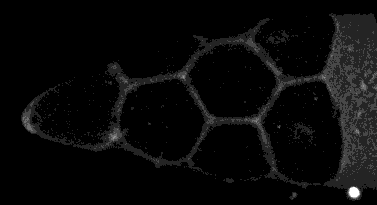
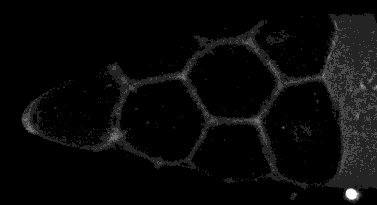
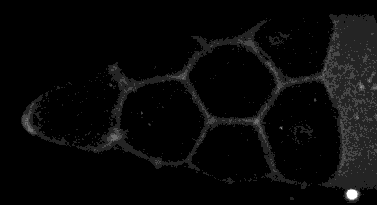
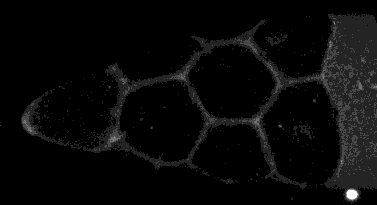
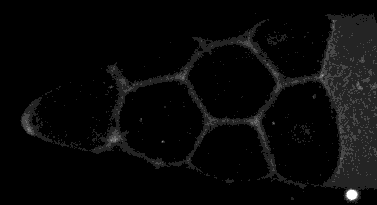
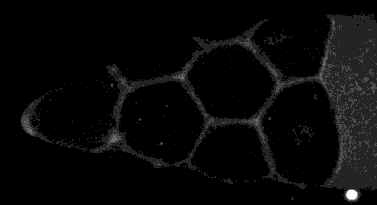
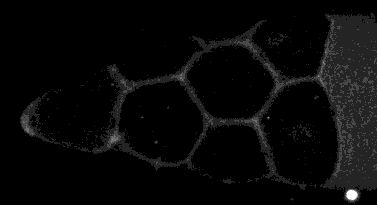
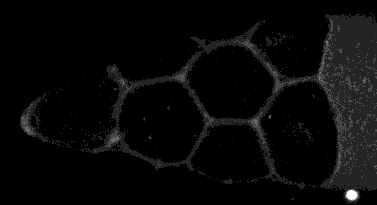
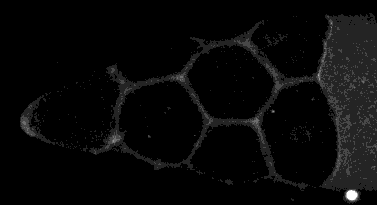
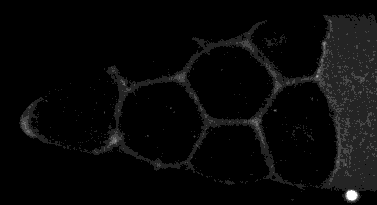
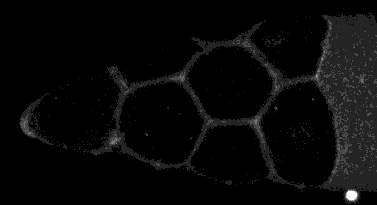
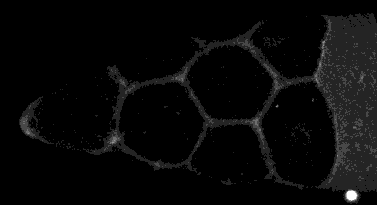
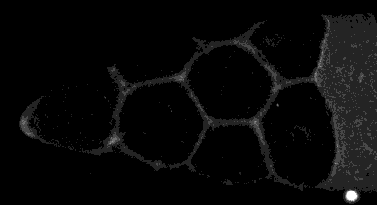
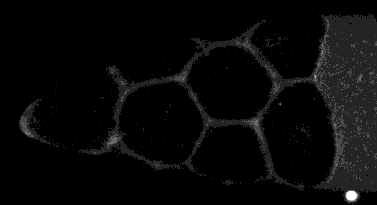
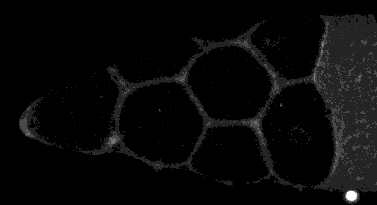
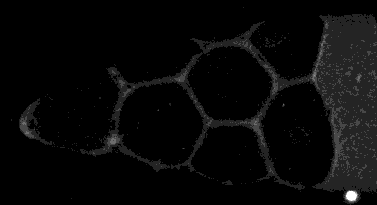
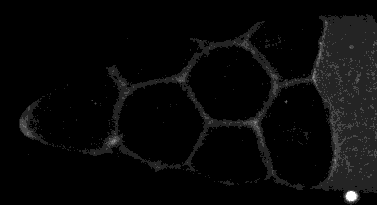
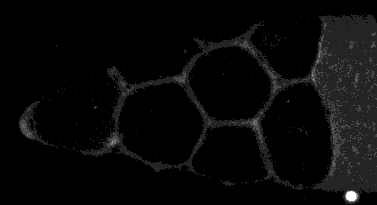
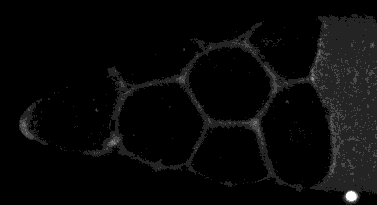
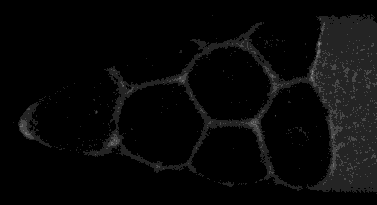
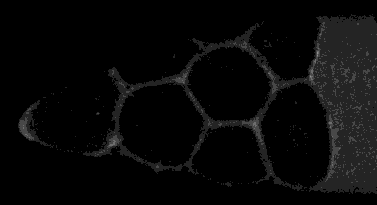
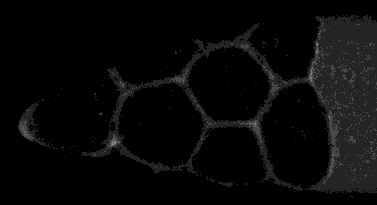
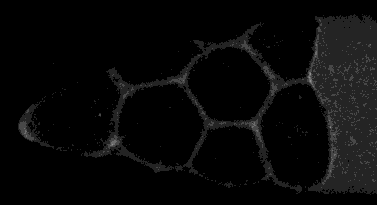
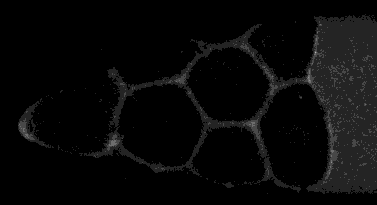
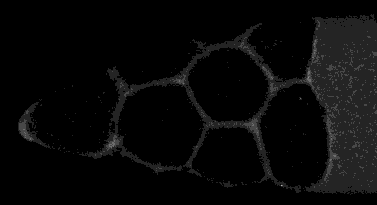
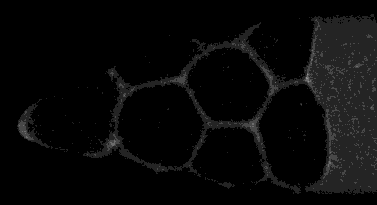
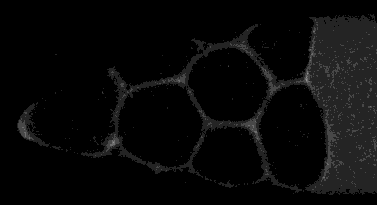
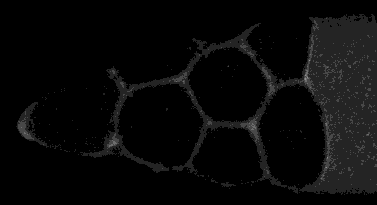
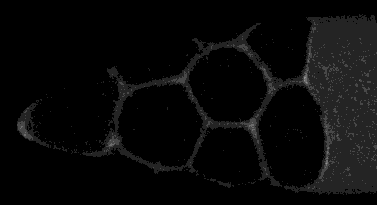
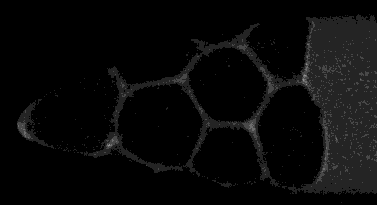
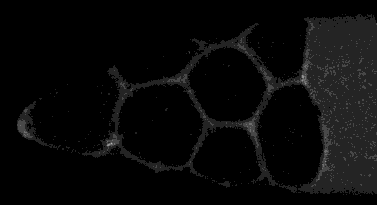
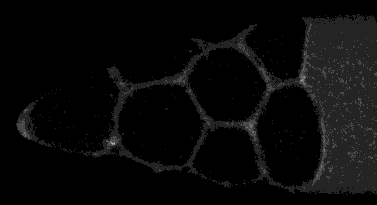
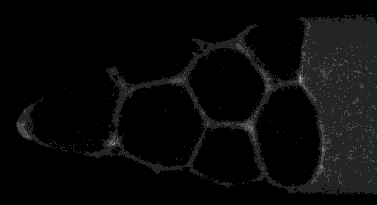
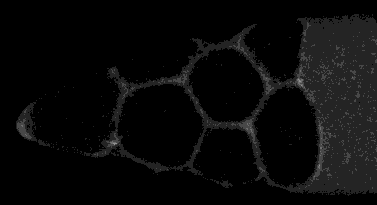
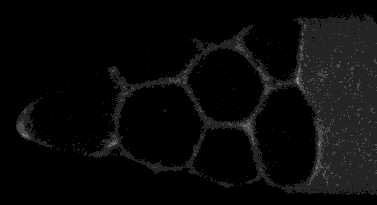
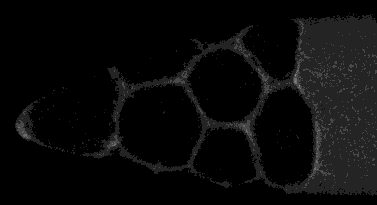
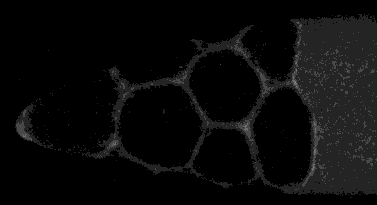
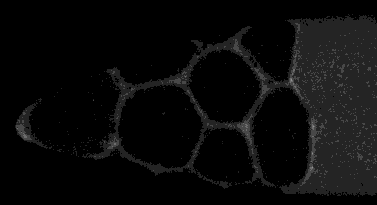
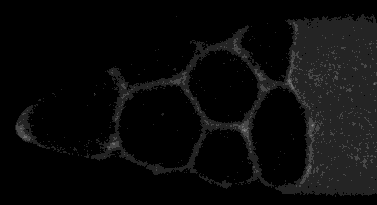
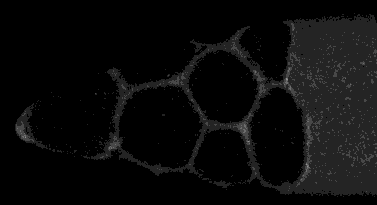
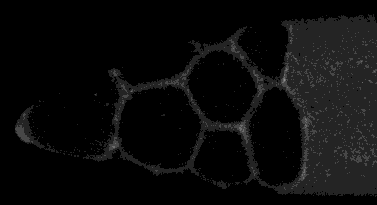
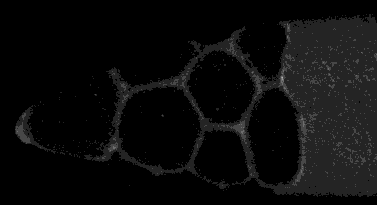
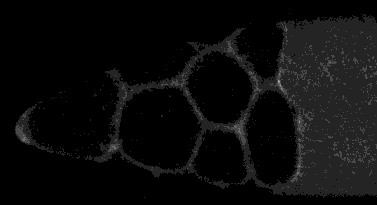
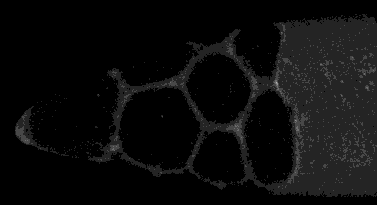
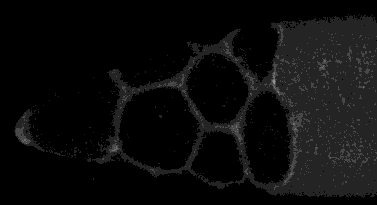
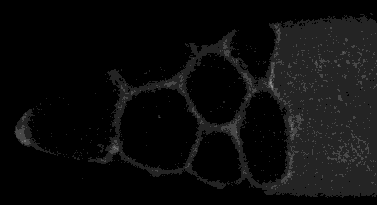
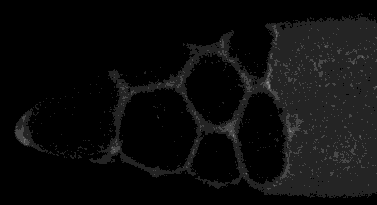
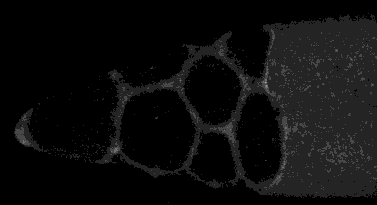
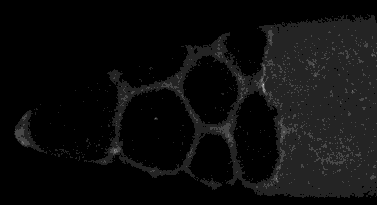
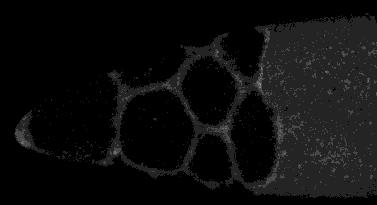
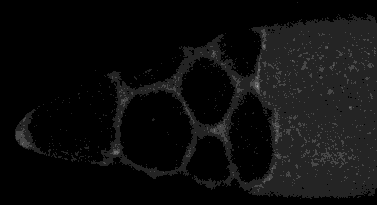
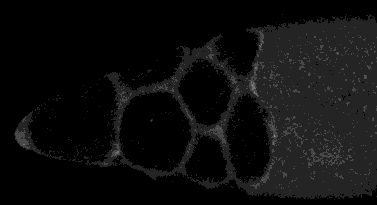
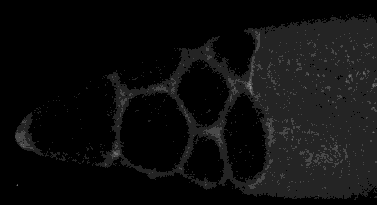
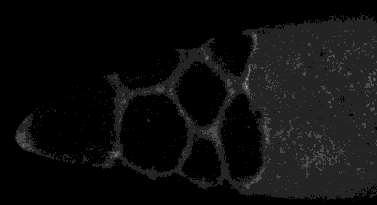
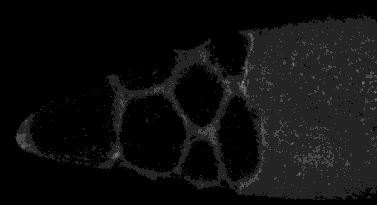
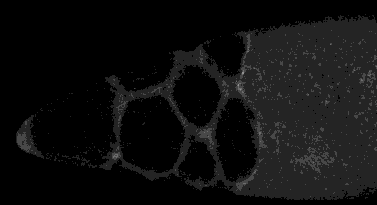
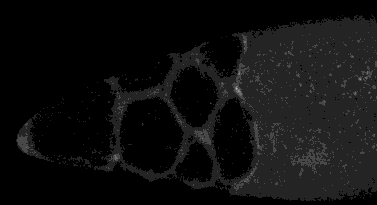
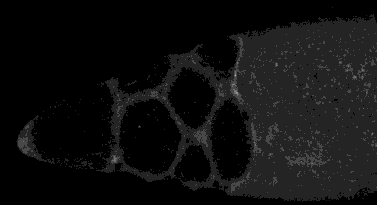
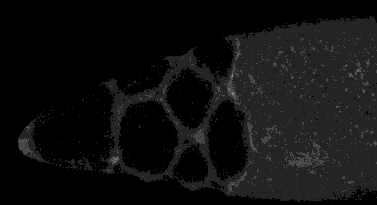
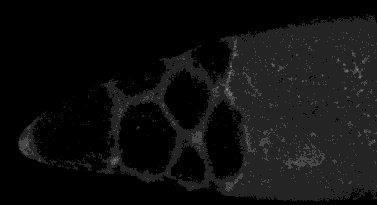
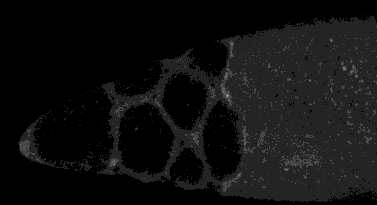
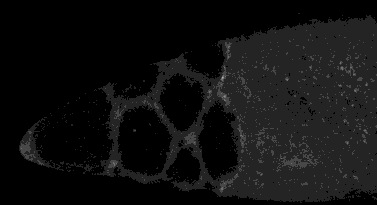
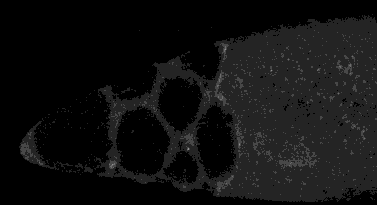
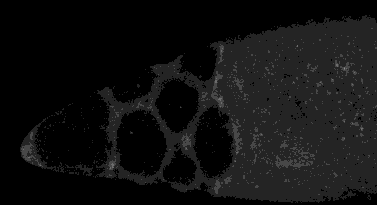
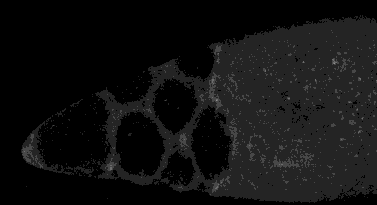
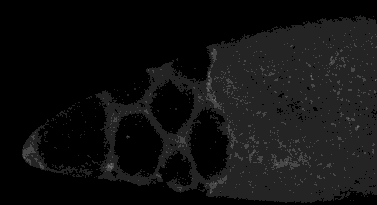
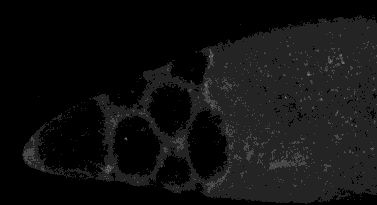
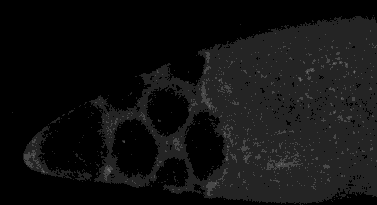
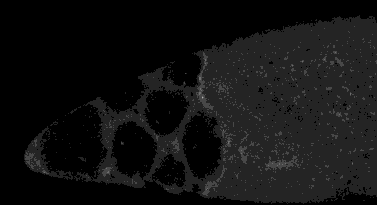
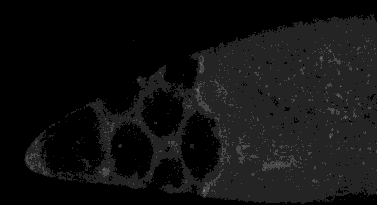
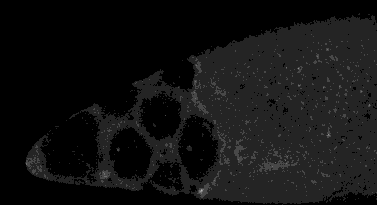
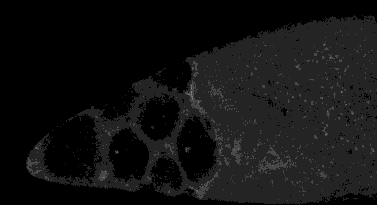
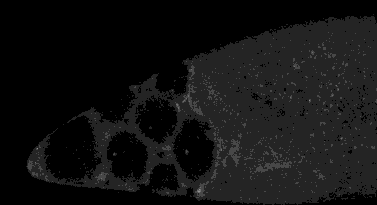
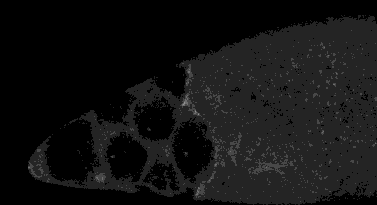
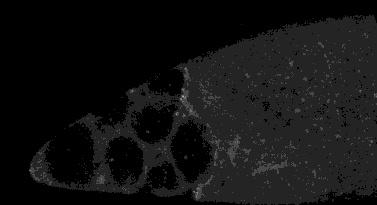
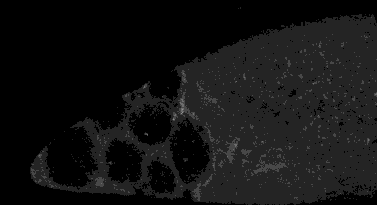
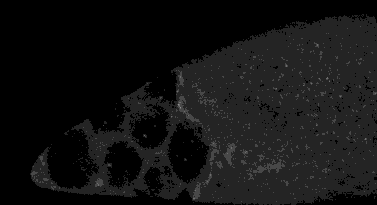
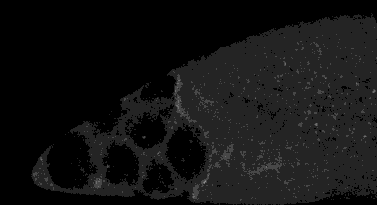
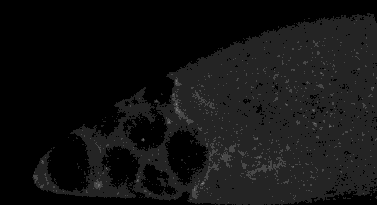
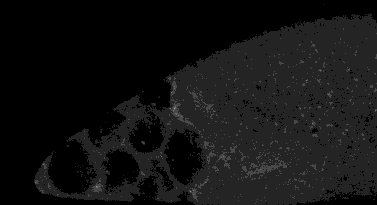
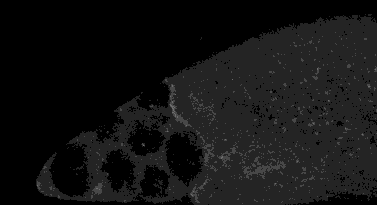
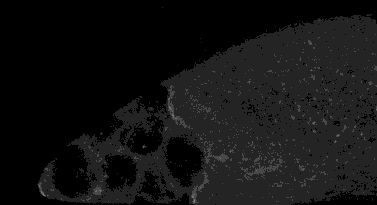
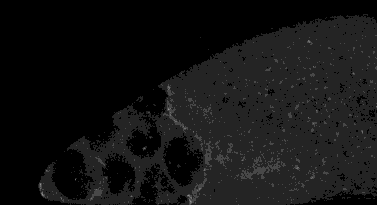
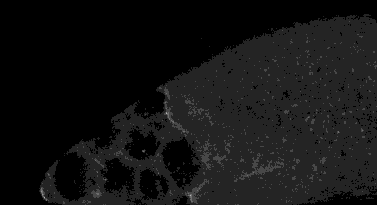
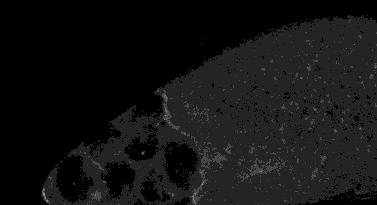
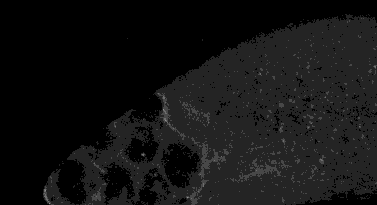
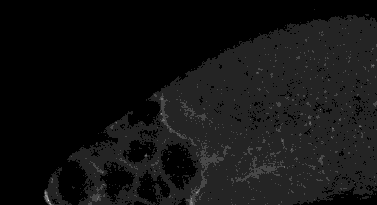
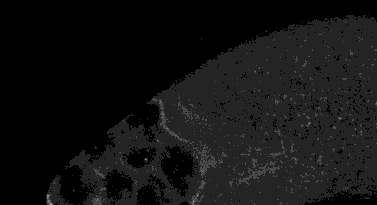
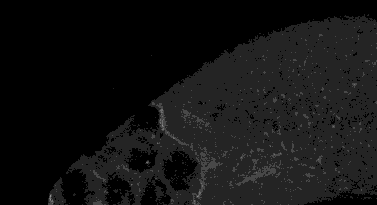
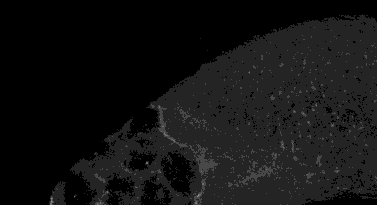
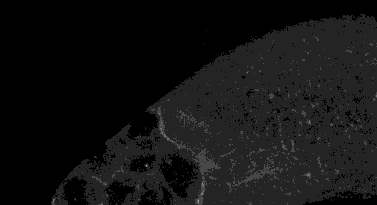
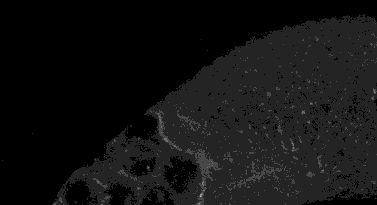

In [ ]:
# Interactive plot, produced using Plotly library. Hover over image for actions: can zoom, pan, or download as PNG.
# Careful dragging the slider to adjust frame. If done too quickly, the animation freezes and you must re-run the cell
vmin, vmax = img2.min(), img2[-100:-1,:,:].max() # Subset in time is because there's a bright spot in earlier frames
fig = px.imshow(
    img2[::5], # Step size of 5 'speeds up' movie - it takes a long time otherwise and breaks more easily
    zmin=vmin,
    zmax=vmax,
    animation_frame=0,
    binary_string=True,
    labels={'animation_frame': 'plane'}
)
# The following two lines increase speed, although I don't know exactly how they work
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
plotly.io.show(fig) # Anterior should be to the left

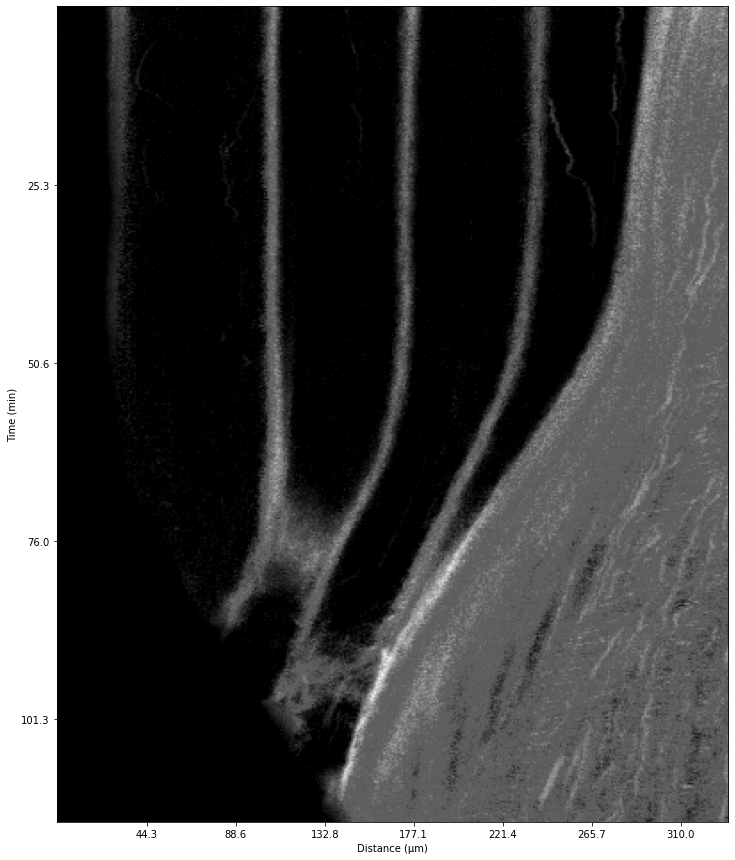

In [ ]:
# Define a line at middle of image
lwid = 5 # Number of pixels on either side of the line to include
midHeight = theshape[1]//2 # Integer division of height dimension - to get the middle of image

# Make the kymograph. Let's be rigorous and convert from indices to time and distance along the axes
if lwid > 0:
    kymo = img2[:,(midHeight-lwid):(midHeight+lwid),:]
    kymo = np.mean(kymo,axis=1)
else:
    kymo = img2[:,midHeight,:]
plt.imshow(kymo,'gray')
# plt.xticks([])  # This will disable xticks. Convenient to know, but not useful here
distTicks = plt.xticks()[0]
distTicks = distTicks[distTicks>0]
distTicks = distTicks[distTicks<=theshape[2]]
timeTicks = plt.yticks()[0]
timeTicks = timeTicks[timeTicks>0]
timeTicks = timeTicks[timeTicks<=theshape[0]]
plt.xticks(distTicks,np.round(distTicks*dx,1))
plt.yticks(timeTicks,np.round(timeTicks*dt/60,1))
plt.xlabel('Distance (µm)')
plt.ylabel('Time (min)')
plt.gcf().set_size_inches(15, 15) # Doesn't seem to work as expected, but it does change the size if adjusted enough
plt.show()

**Interpreting the kymograph**
1. About how much time passes between the start of the movie and the beginning of motion?
2. Can you tell in what order the four 'layers' of nurse cells shrink? These layers should be clearly visible from your kymograph.
3. 60 minutes into the movie, at approximately what speed is the oocyte's anterior edge moving forward? You can simply estimate this by eye, or you could try to find a way to accurately measure it if you're interested / have extra time.

**Go further** This dataset was adjusted beforehand to align horizontally. Think about how you would make the same type of kymograph for an image where the useful axis is at an angle (say $45^o$ - it's the easiest to visualize, and the same idea works for other angles). There are at least two different options to consider.

Here's the kymogrph used in the paper. It was created in FIJI instead of Python, used a subset of frames of the movie, and was also adjusted in contrast and colormap, so it will appear slightly different from yours. However, the general features should be the same.
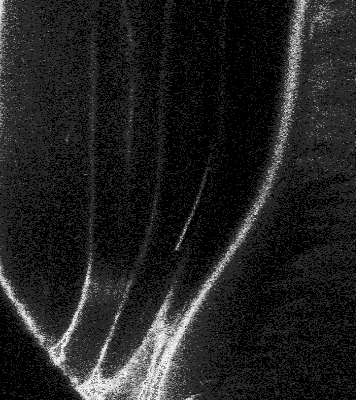

### Kymographs in FIJI

FIJI provides relatively easy methods to produce more complicated kymographs, including those along curved lines, at angles to the horizontal axis, using lines of different width, and even ones that update as you select locations on the image. We'll try some of those now.

#### Automatically-updating kymographs

This method takes advantage of a FIJI command meant for viewing z-stacks from three orthogonal views (e.g. top-down, side-on, and front-on).
- Open 112419_EcadGFP_live_rotated_cropped.tif, which is similar to the movie used above. It's ~1.4 GB, so if the file size is a problem, try 112419_EcadGFP_live_rotated_cropped_everyFourth.tif, which is just every fourth frame of that movie. This movie is 4D (xyzt) data, and by default, you get a view from the top down.
- Select 'Image > Stacks > Orthogonal Views' (Cmd + Shift + H if using a Mac). This opens the side and front views of the egg chamber. Adjust the slider to change frame, and see how the views change. When you're done, close the orthogonal views but leave the original image open.
- Now we lie to FIJI to get a kymograph. Select 'Image > Hyperstacks > Re-order Hyperstack ...' and flip the z and t dimensions.
- Open orthogonal views again. Since FIJI is reading the stack as xytz now, it's showing a view through time - a kymograph. Adjusting the z-position will update the kymograph, as will clicking on the image.

But this still requires the useful dimension be aligned with an axis of the figure. We could rotate an image such that the main axis is aligned properly, but there are other ways.

#### Kymographs along a defined line

FIJI lets you make kymographs along arbitrary lines (straight or curved) of different widths. Let's make a straight-line version first and adjust width to reproduce the above kymograph, then use a curved line.

Analyze > Multi Kymograph > Multi Kymograph should come included with the FIJI download, and it's easy to use.

Straight line version, using the same image as above:
- Click the 'line' button in the FIJI tool bar. Draw any line (for example, the anterior-posterior axis), then go to Analyze > Multi Kymograph > Multi Kymograph. Choose a line width, and a kymograph should pop up. Try a few different widths and see what happens.
- Double-click the 'line' button, and you should get a slider for line width. This lets you preview how thick a line will be for a given length.

Curved-line version, using MAX_102918_clip170GFP_sqhCH_live_t153-243.tif (use the second channel, where waves of myosin are visible):
- Right-click on the 'line' button and select 'Segmented Line'. Click a few points to make a set of connected line segments. To set a final point and finish drawing, right-click or double-click. Next to the line-width slider, click on 'Spline fit' to make your line curved if necessary. Try to make a kymograph where you can see the wave moving cyclically around the perimeter of one of the cells in the image.

## Exercise set #3 - Identify, segment, and measure sizes of cells/nuclei using 'regionprops'

This exercise includes:
- Separating nuclei from background using thresholding
- Associating a label to each individual nucleus ('connected-components labeling')
- Measuring properties from each nucleus, as well as number of nuclei (and hence number of cells, typically)

(2048, 2048, 3)


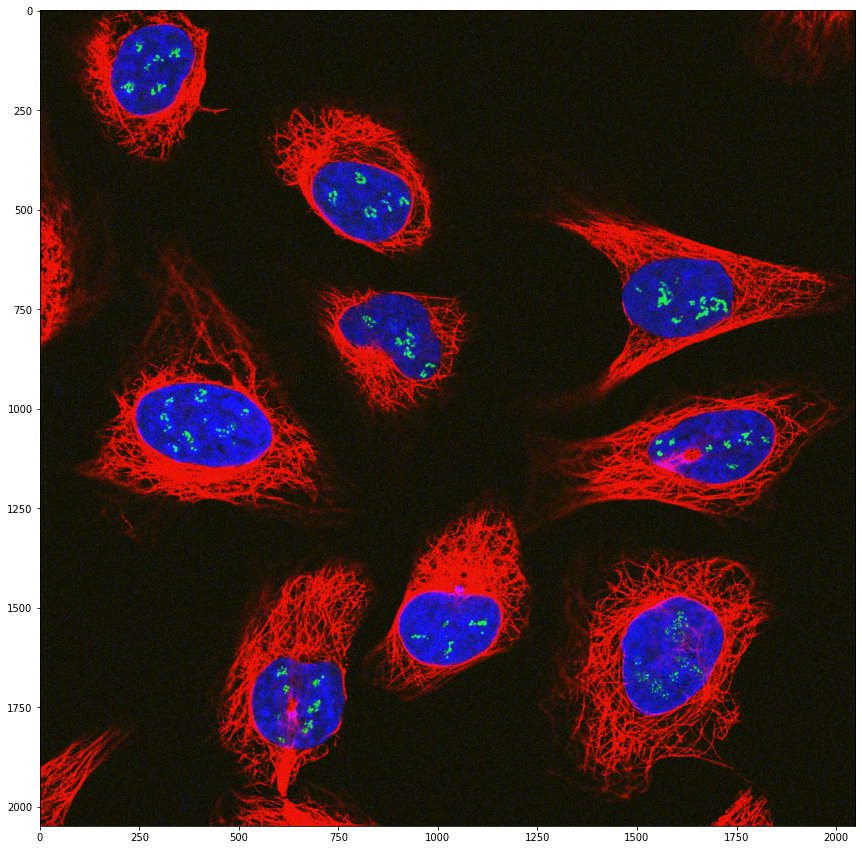

In [ ]:
# Read in an image to use. This one comes from an online database of cell images
%matplotlib inline
# Back to in-line view
fname = '/content/gdrive/MyDrive/QMW_files/40491_noise.tif' # Image from http://cellimagelibrary.org/images/40491
                                                            # Uhlen M. et al. Nat Biotech 2010
                                                            # Noise added using FIJI's 'Add Noise'/'Salt and Pepper'
dx = 0.0801 # Pixel spacing, in µm, for 40491_noise.tif
img3 = cv2.imread(fname)
# Because of a quirk of openCV, RGB images are read in as BGR (don't ask why, please...)
img3 = img3[:,:,[2, 1, 0]] # So we flip the order of the channels, getting back to RGB
print(np.shape(img3)) # RGB, so third dimension is color. In this image: [microtubules, nucleolus, DNA]
plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(img3)
plt.show()

We'll work with the DAPI (DNA label) channel. DAPI staining is a common way to locate cells within an organism/tissue, and it's often 'cleaner' (higher signal-to-noise ratio) relative to other labels. Plus, it's the easiest thing to use in these example images.

Becuase this image is (artificially) noisy, we'll want to clean it up first. This can be done in various ways, including blurs or background subtraction functions before thresholding, but let's do the cleaning *after* thresholding this time.

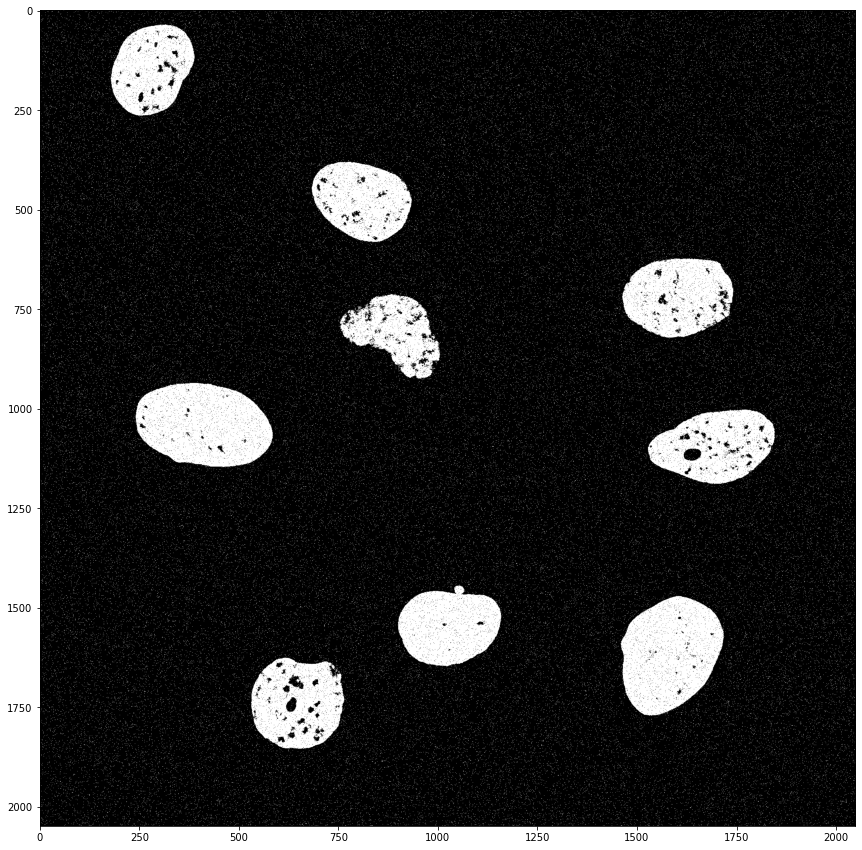

In [ ]:
# Pull out DAPI channel and threshold
dapi = img3[:,:,2]
thresh, dapiBin = cv2.threshold(dapi,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Returns threshold, then mask
plt.imshow(dapiBin,'gray')
plt.show()

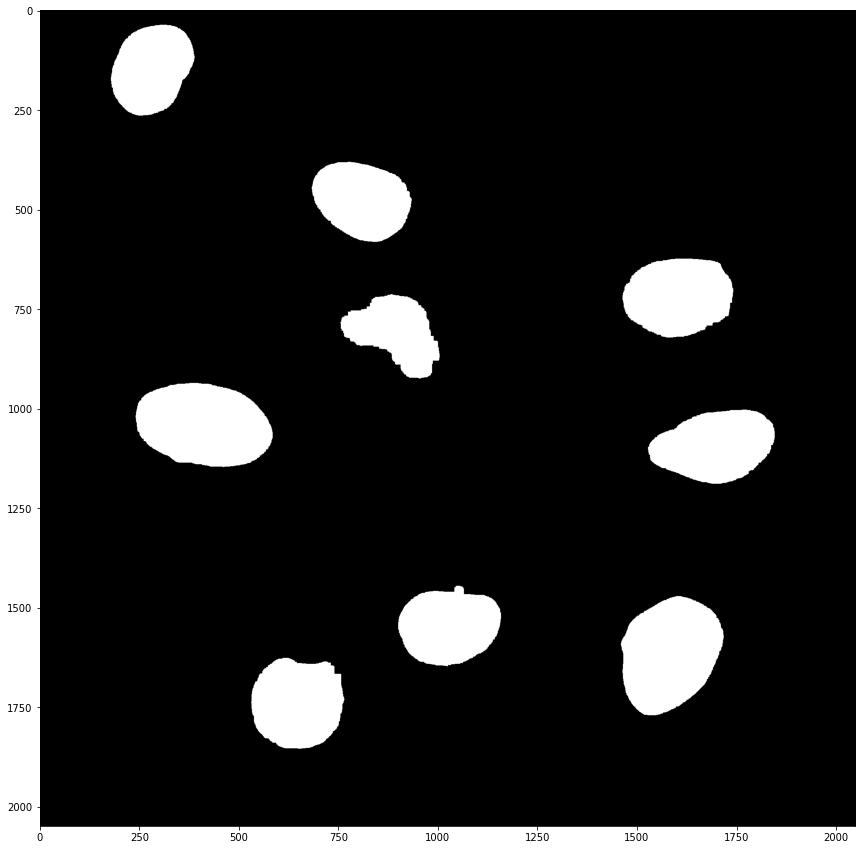

In [ ]:
# There's some noise in the form of random bright pixels in the background. This can be fixed several ways.
# There is also a problem of holes and dark spots in the nuclei themselves. Again, several solutions exist.

# Morphological operation way: opening and closing
kernelOpen = np.ones((3,3))
kernelClose = np.ones((25,25))
cleaner = cv2.morphologyEx(cv2.morphologyEx(dapiBin, cv2.MORPH_OPEN, kernelOpen), cv2.MORPH_CLOSE, kernelClose)
# cleaner = cv2.morphologyEx(cv2.morphologyEx(dapiBin, cv2.MORPH_CLOSE, kernelClose), cv2.MORPH_OPEN, kernelOpen)
plt.imshow(cleaner, 'gray')
plt.show()

Note on kernel sizes and order of operations:
- Small bright spots to clear -> small kernel for opening
- Large holes to fill -> large kernel for closing
- Try this with the reversed order. It should end *badly* if the closing kernel is large and the opening is small.
    - To get a clear idea of why this fails, try a kernel size of 11 for closing and 3 for opening, in that order.
- What do you think will happen if the kernel size for closing is greater than the distance between nuclei? If unsure, try it!
    
An alternative approach to accomplish this cleanup: [scipy.ndimage.morphology.binary_fill_holes](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.binary_fill_holes.html) instead of the closing step. This is probably better, since it doesn't require you to choose a kernel size and is less likely to do unexpected things, but you'll have to import it.

Now you should have a mask clearly showing several nuclei. Let's get some numbers for them!

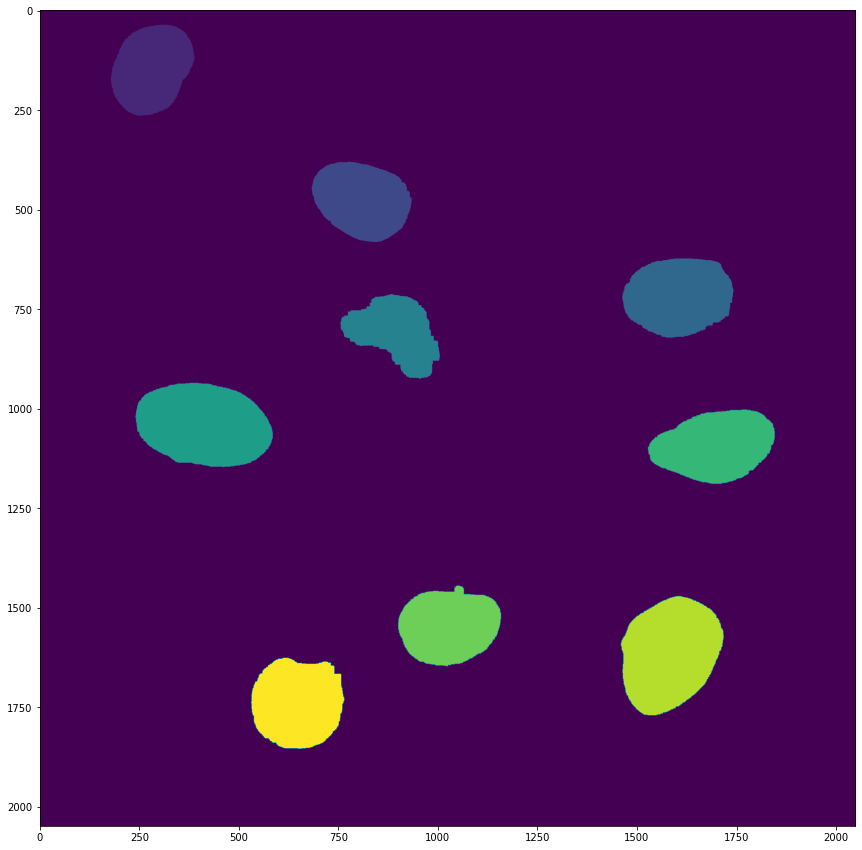

There are 9 nuclei.
Nucleus         Size (pixels)   Area (µm^2)     Centroid x      Centroid y      Angle (rad)     Aspect Ratio
1               35712           229.1           147.3           279.9           -0.547          1.323     
2               37511           240.7           476.9           807.9           1.187           1.373     
3               43369           278.3           718.6           1602.0          -1.457          1.421     
4               31350           201.1           809.7           892.2           1.022           1.557     
5               56630           363.3           1041.3          410.3           1.394           1.700     
6               42888           275.2           1093.6          1693.9          -1.400          1.797     
7               38912           249.7           1546.2          1025.4          -1.433          1.369     
8               56676           363.6           1615.9          1580.2          -0.522          1.332     
9              

In [ ]:
# Object labels and counts
labelarray = measure.label(cleaner)
plt.imshow(labelarray)
plt.gcf().set_size_inches(15, 15)
plt.show()

# More detailed data, outputted using fancy print functions to make a rough table
print('There are %d nuclei.' % np.max(labelarray))
# print('There are {} nuclei.'.format(np.max(labelarray))) # Another way to do this
props = measure.regionprops(labelarray) # Lots of properties, stored in a (number of nuclei)-element list
# for prop in props:axis_major_lengthfloat
#     print('Nucleus {}: {} pix'.format(prop.label, prop.area))
print ("{:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<10}".format('Nucleus','Size (pixels)', 'Area (µm^2)', 
                                                         'Centroid x','Centroid y','Angle (rad)','Aspect Ratio'))
for prop in props:
    cent = np.round(prop.centroid,1)
#     ang = np.round()
    ar = prop.major_axis_length/prop.minor_axis_length
    print("{:<15} {:<15} {:<15.1f} {:<15.1f} {:<15.1f} {:<15.3f} {:<10.3f}".format(prop.label, prop.area,
                                                                                   prop.area*dx*dx, cent[0], cent[1],
                                                                                   prop.orientation, ar))

**Going further**
1. This is a very simple example. Try using the human cell example (below) for a more complex one with smaller and more numerous nuclei. This is a case where it's actually helpful to automate nucleus counting, because counting all these cells by hand would be unpleasant.
2. If #1 was easy, try with the fruit fly (*Drosophila melanogaster*) cell examples (also below). These cells tend to clump more, so separating objects is harder.
    - This is likely a great time to use watershed segmentation (as in Exercise set #5), but in a different way than you'll use there. See https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html for more information on this approach.
3. Try this same process with the microtubule channel of the image, trying to get the cell size and orientation. This is a much less convenient label to find a cell body than something like a plasma membrane label or a free GFP, but it might be possible if the microtubules are dense enough.
    - You'll probably need to do some blurring before the thresholding step.

In [ ]:
# Examples taken from sample data at https://cellprofiler.org/examples/
    # None of these included metadata I could find, so the pixel spacing isn't known

# Human cells
fname_human = '/content/gdrive/MyDrive/QMW_files/AS_09125_050116030001_composite_RGB.tif'
dx = 1 # Placeholder

# Drosophila melanogaster cells
    # There are three different images here, each grayscale, showing only DAPI channel
fname_dmel_1 = '/content/gdrive/MyDrive/QMW_files/01_POS218_D.tif'
fname_dmel_2 = '/content/gdrive/MyDrive/QMW_files/01_POS002_D.tif'
fname_dmel_3 = '/content/gdrive/MyDrive/QMW_files/01_POS076_D.tif'
dx = 1 # Placeholder

(512, 512, 3)


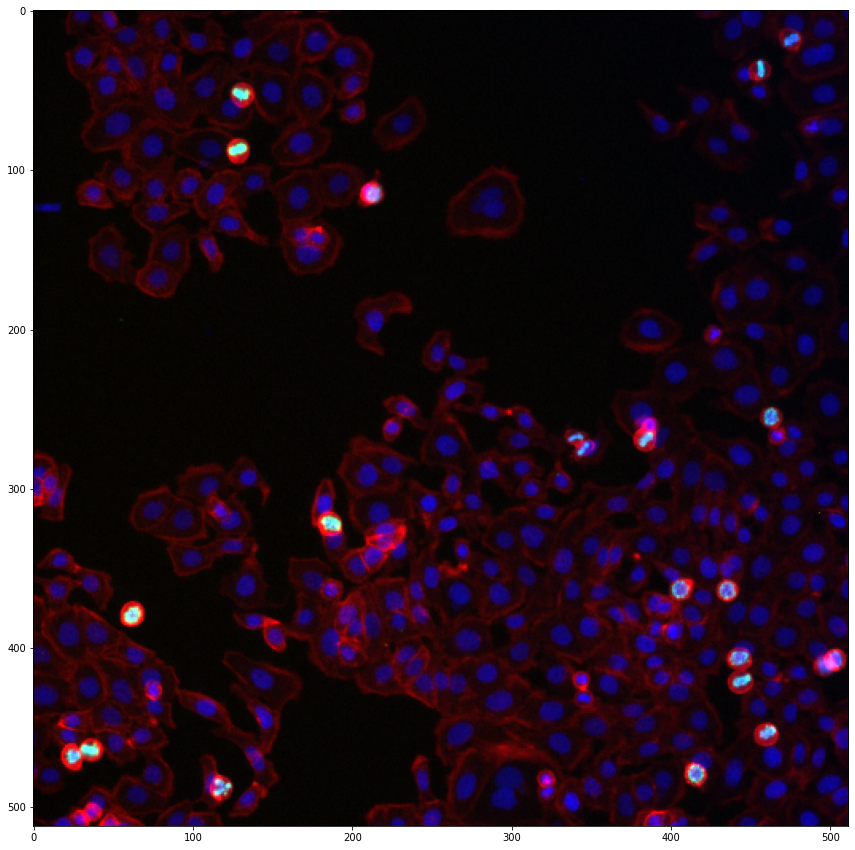

In [ ]:
fname_human = '/content/gdrive/MyDrive/QMW_files/AS_09125_050116030001_composite_RGB.tif'
dx = 1 # Placeholder
img3_2 = cv2.imread(fname_human)
img3_2 = img3_2[:,:,[2, 1, 0]]
print(np.shape(img3_2))
plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(img3_2)
plt.show()

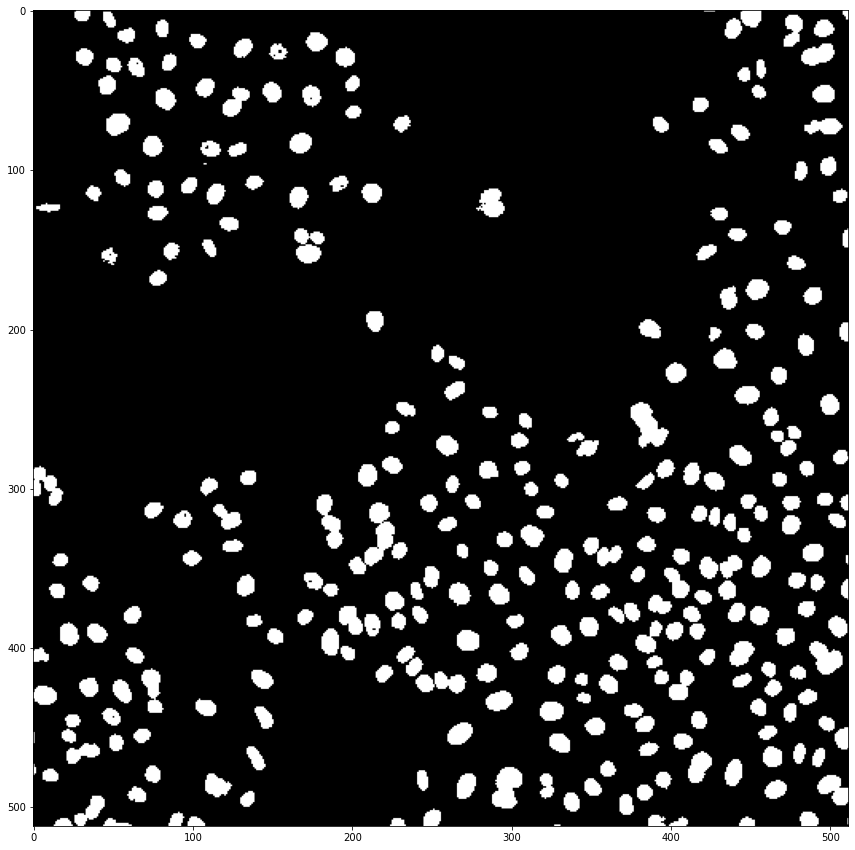

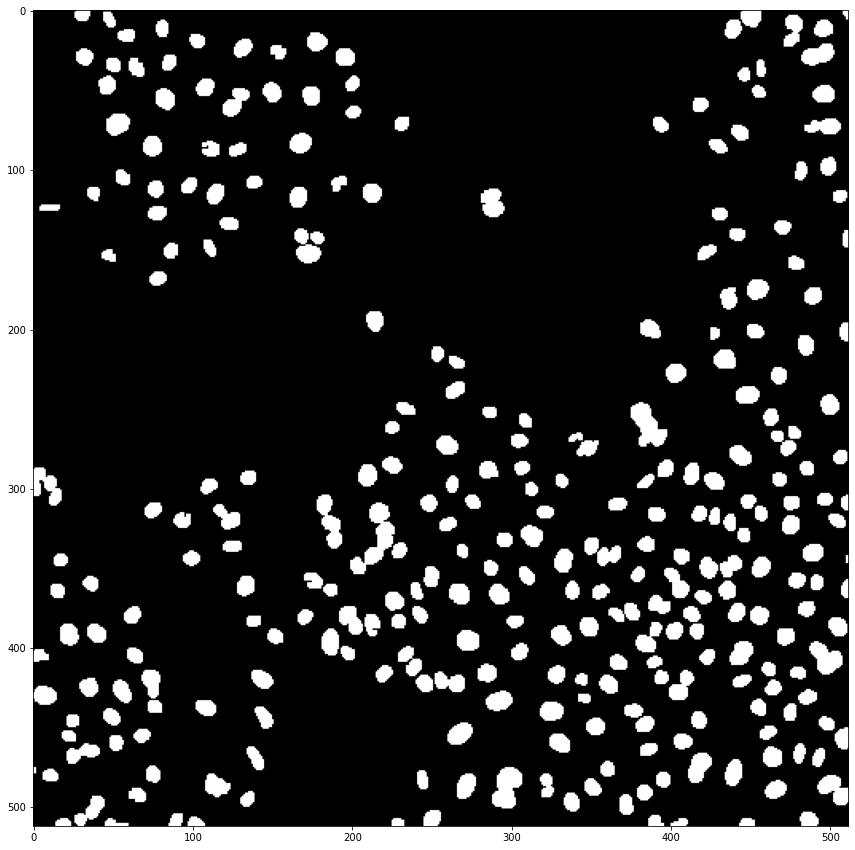

In [ ]:
# Pull out DAPI channel and threshold
dapi = img3_2[:,:,2]
thresh, dapiBin = cv2.threshold(dapi,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Returns threshold, then mask
plt.imshow(dapiBin,'gray')
plt.show()

# There's some noise in the form of random bright pixels in the background. This can be fixed several ways.
# There is also a problem of holes and dark spots in the nuclei themselves. Again, several solutions exist.

# Open
kernelOpen = np.ones((3,3))
cleaner_2 = cv2.morphologyEx(dapiBin, cv2.MORPH_OPEN, kernelOpen)

# Fill holes (closing doesn't work because nuclei are too close together))
notHoles = cleaner_2.copy()
mask = np.zeros((notHoles.shape[0]+2, notHoles.shape[0]+2), np.uint8) # Need to pass this to the flooding function
cv2.floodFill(notHoles, mask, (0,0), 255) # Flood
holes = cv2.bitwise_not(notHoles) # Invert to get only holes inside cells
clean_2 = cleaner_2 | holes # 'Or' function to fill holes

# cleaner = cv2.morphologyEx(cv2.morphologyEx(dapiBin, cv2.MORPH_CLOSE, kernelClose), cv2.MORPH_OPEN, kernelOpen)
plt.imshow(clean_2, 'gray')
plt.show()

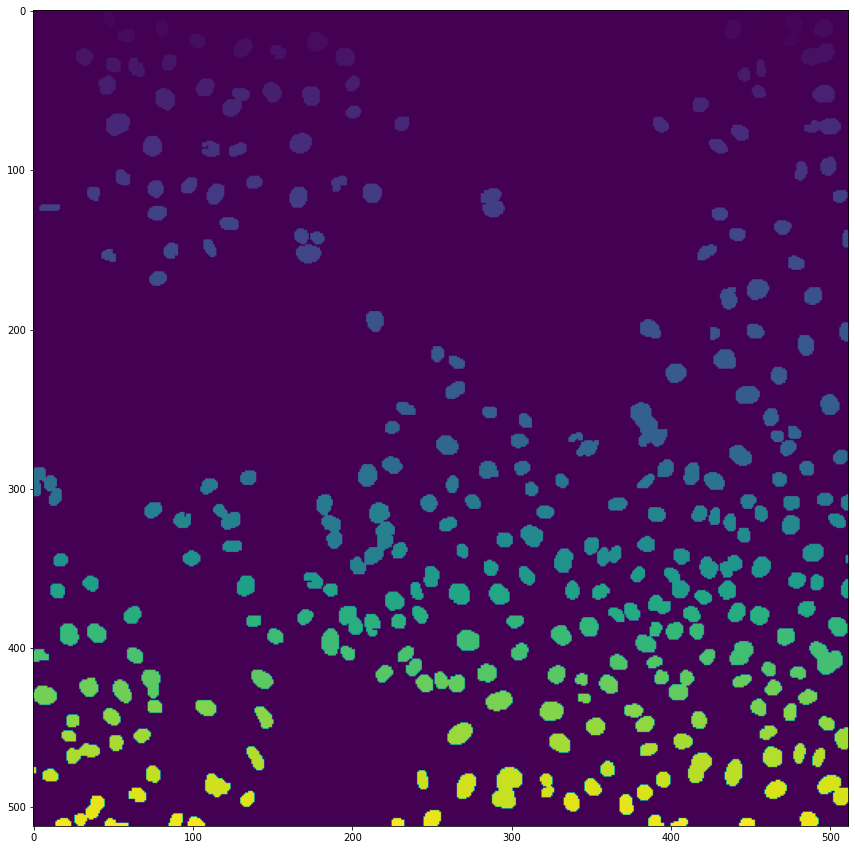

There are 291 nuclei.


In [ ]:
# Object labels and counts
labelarray = measure.label(clean_2)

plt.imshow(labelarray)
plt.gcf().set_size_inches(15, 15)
plt.show()

print('There are %d nuclei.' % np.max(labelarray))

Could be cleaner. For example, a distance-transform watershed (described below, in the context of FIJI) and exclusion of nuclei touching the edge of the image would make results better. Could also filter out spots that are clearly too large to be a single nucleus.

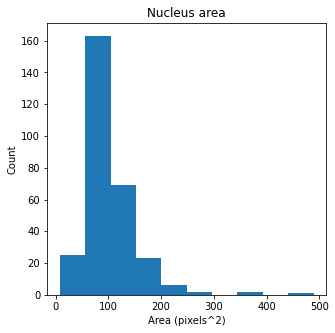

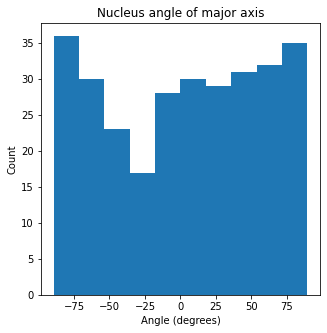

In [ ]:
# More detailed data, with some summary statistics of size (a table would be unwieldy to read)
props = measure.regionprops(labelarray) # Lots of properties, stored in a (number of nuclei)-element list
sizes = [props[i].area for i in range(len(props))]
oris = [props[i].orientation for i in range(len(props))]
np.mean(sizes) # Gives average nucleus size

plt.hist(sizes)
plt.title('Nucleus area')
plt.ylabel('Count')
plt.xlabel('Area (pixels^2)')
plt.gcf().set_size_inches(5, 5)
plt.show()

plt.hist(np.array(oris)*180/np.pi)
plt.title('Nucleus angle of major axis')
plt.ylabel('Count')
plt.xlabel('Angle (degrees)')
plt.gcf().set_size_inches(5, 5)
plt.show()

### FIJI's version

Let's try the human cell example in FIJI.
- Open the image and extract the channel containing the nuclei.
- Threshold the image (with or without blurring or background subtraction first; up to you, but look at the image and consider whether blurring could introduce problems later on). Slect 'Image > Adjust > Threshold'. Try out different built-in thresholding algorithms to see what works best (though Otsu is still a good choice for this image).
- There will likely still be a few touching cells. One approach is a distance-transform watershed (explained in the link a couple cells back, but basically, it creats an image where each pixel's value is the distance from that pixel to the background, then uses local maxima in that image as seed points for watersheds). If you have the MorphoLibJ plugin installed, that's 'Plugins > MorphoLibJ > Binary Images > Distance-transform Watershed'. Leave the distance function as is and try adjusting the 'Dynamic' parameter, with and without the 'Normalize weights' box checked. Details on each option here: https://imagej.net/plugins/distance-transform-watershed
    - If you don't have MorphoLibJ, 'Process > Binary > Watershed' is a decent alternative, though you have no control over how it runs.
- 'Analyze > Analyze Particles' is FIJI's version of Python's 'regionprops' we used earlier. You can set minimum/maximum object sizes to exclude junk the threshold didn't catch or clumps of nuclei if you are okay losing a few nuclei. Circularity is how round the object is; 1 is a perfect circle, while long, thin objects approach 0.
    - You can choose how to display results. 'Display results' gives you a table of results, and you can choose what metrics to include in 'Analyze > Set measurements' before running this function. I like using 'Show Overlay Masks' to see what objects FIJI finds.
    - Whether you clear objects touching the edge depends on the application - e.g. counting nuclei, it's not necessary, but for measuring size, it is.

## Exercise set #4 - Use watershed segmentation to measure nucleus volume (in 3D) and look for patterns

This exercise includes:
- Working with 3D data of nuclear membranes
- Using the watershed technique to extract nucleus outlines
- Associating a volume to each nucleus
- Making a fun image - color-coding nuclei by their volume

In [ ]:
# Metadata you'll need
dx = 0.1610 # Pixel spacing in µm in x,y dimensions
dx = dx*2 # If using the downsampled version
dz = 1 # Pixel spacing in z (often, dz > dx spacing in real data like this. Resolution is also worse in z than in x,y)

In [ ]:
fname = '/content/gdrive/MyDrive/QMW_files/2021-01-09_Nup107GFP_Image2.tif' # ~160 MB image
fname = '/content/gdrive/MyDrive/QMW_files/2021-01-09_Nup107GFP_Image2_downsampled2x_inXY.tif' # 38  MB image, if above takes too long
ret, img4 = cv2.imreadmulti(fname, [], cv2.IMREAD_ANYDEPTH) # We want to keep this 16 bit, hence the last argument

In [ ]:
img4[0].shape

(321, 591)

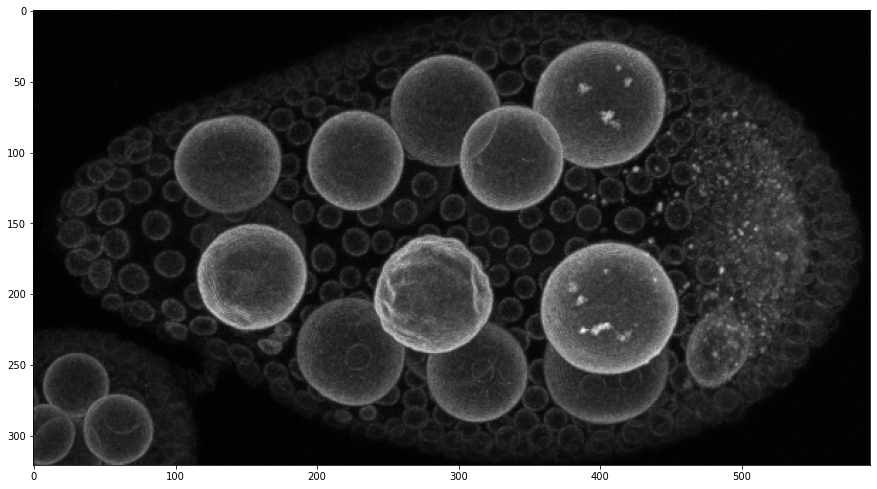

In [ ]:
# To get a handle on what we're looking at, read in the 3D data and make a projection of it through z dimension
fname = '/content/gdrive/MyDrive/QMW_files/2021-01-09_Nup107GFP_Image2.tif' # ~160 MB image
fname = '/content/gdrive/MyDrive/QMW_files/2021-01-09_Nup107GFP_Image2_downsampled2x_inXY.tif' # 38  MB image, if above takes too long
ret, img4 = cv2.imreadmulti(fname, [], cv2.IMREAD_ANYDEPTH) # We want to keep this 16 bit, hence the last argument
img4 = np.transpose(img4, [1,2,0]) # To get into format with z as the third dimension. Really just preference, but may affect behavior of functions down the line
# img4 = np.array(img4)
proj = np.max(img4, 2) # Maximum intensity projection (MIP) along z-dimension
# proj = np.mean(img4, 2) # Average intensity projection along z-dimension
plt.imshow(proj,'gray')
plt.show() # Anterior is to the left if all is working properly

In [ ]:
np.dtype(img4[1,1,1]) # Note again that this is 16-bit instead of 8

dtype('uint16')

In [ ]:
# Interactive plot - this is a larger dataset than before, so it can take a few seconds to run
vmin, vmax = img4.min(), img4.max()
fskip = 2 # Set to 1 to see whole stack; higher numbers mean seeing only a few slices
fig = px.imshow(
    img4.transpose([2,0,1])[::fskip,:,:], # Requires [z,y,x format]
    zmin=vmin,
    zmax=vmax/1.5,
    animation_frame=0,
    binary_string=True,
    labels={'animation_frame': 'plane'}
)
# The following two lines increase speed, although I don't know exactly how they work. Remove them if it glitches
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
plotly.io.show(fig)

Output hidden; open in https://colab.research.google.com to view.

Now we have our data and know what the nuclei look like. Time to segment them!

A common first step is to preprocess the image to make the watershed algorithm happier. If you like, skip the preprocessing and see how the algorithm does. Depending on the image, it might work, but some simple steps beforehand can greatly improve the likelihood you'll get good results.

In [ ]:
# Background subtraction using 'rolling ball' algorithm, as used in FIJI's 'Subtract Background' function
    # For this image, background subtraction has little obvious effect, so skip this if it's too slow to run
    # Python's version of this algorithm is slow compared to FIJI's. It took ~60 seconds on my laptop vs ~10 in FIJI.
bgSub_img4 = np.copy(img4) # np.copy() because we'll change bgsub_img4 but don't want to change img4 itself
start = time.time() # This will be slow, so it's worth timing to know when troubleshooting how long it will take
for i in range(img4.shape[2]): # For each slice in z
    bgSlice = res.rolling_ball(img4[:,:,i],radius=30)
    bgSub_img4[:,:,i] -= bgSlice
end = time.time()
print(end-start) # Elapsed time in seconds - original image took ~60-75 seconds on my laptop (Jupyter) and longer on Colab (~400-450 seconds)

# If this is taking forever to run, skip and and set bgSub_img4 = img4 before running the next cells

102.94206595420837


In [ ]:
# Can skip viewing this in detail - not much different to the eye than the original image
vmin, vmax = bgSub_img4.min(), bgSub_img4.max()
fskip = 2 # Set to 1 to see whole stack; higher numbers mean seeing only a few slices
fig = px.imshow(
    bgSub_img4.transpose([2,0,1])[::fskip,:,:], # Requires [z,y,x format]
    zmin=vmin,
    zmax=vmax/2.0,
    animation_frame=0,
    binary_string=True,
    labels={'animation_frame': 'plane'}
)
# The following two lines increase speed, although I don't know exactly how they work
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
plotly.io.show(fig)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Blur to suppress remaining noise and help fill in small dark holes in what should be the foreground
# medimg4 = cv2.GaussianBlur(bgSub_img4,(3,3),2) # Probably a better choice if done well, but harder to tune
medimg4 = cv2.medianBlur(bgSub_img4,5)

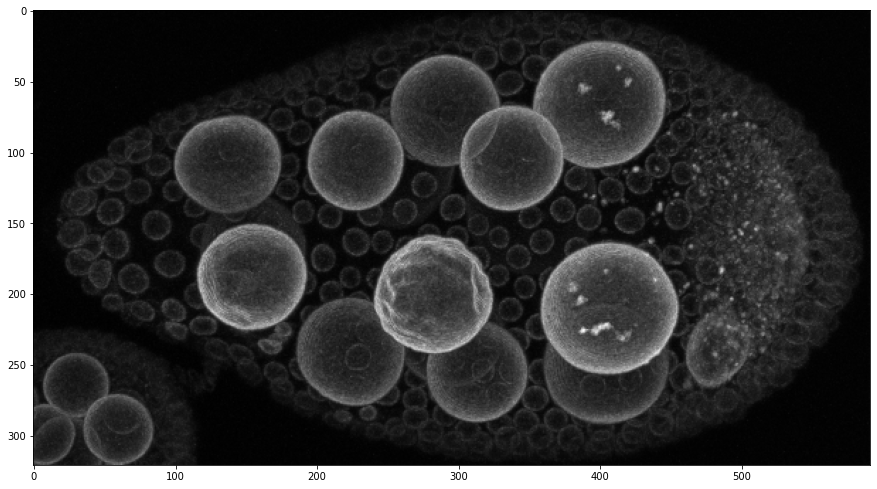

In [ ]:
plt.imshow(np.max(bgSub_img4,2),'gray')
plt.show()

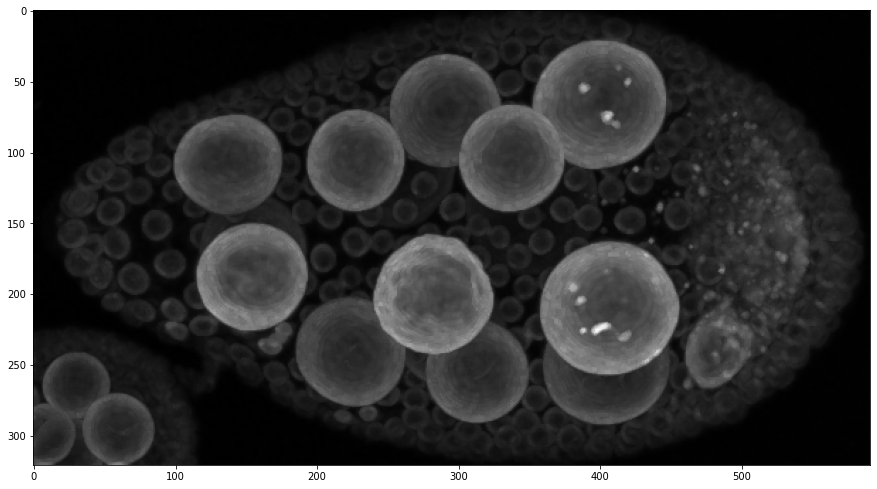

In [ ]:
# plt.imshow(np.max(bg,2))
plt.imshow(np.max(medimg4,2),'gray')
plt.show()

Now for the watershed algorithm. In our data, it's not immediately obvious how to restrict flooding to objects representing the nurse cell nuclei; after all, there are many small nuclei belonging to other cells, plus autofluorescence from the oocyte. One could probably use more clever processing to extract only the fifteen nurse cell nuclear membranes, but there's a simpler way.

Watershed algorithms require a 'seed point' from which to start flooding and stop when they reach 'high' enough regions (i.e. bright regions with darker regions outside). By using sixteen seed points, one per nurse cell nucleus and one for the oocyte nucleus, we restrict analysis to the nuclei of interest.

There's a FIJI plugin (MorphoLibJ) allowing a user to scroll through the stack and click on seed points, but I haven't found a way to do so in Python. That leaves us with the annoying manual approach, but I promise it's worth it!
- Use Plotly to look through the preprocessed stack.
- Note [x,y,z] coordinates of the seed points you want to use. Remember, the first dimension is height when viewing images, and the second is width. Multiple possible seeds will give the same results, so these don't have to be perfect. If segmentation fails, sometimes moving the seed slightly will fix the problem.
- Use these coordinates to set seed points. Unfortunately, the function requires the marker matrix to be the same size as the image, so you'll need zeros everywhere BUT the seed points, with a different integer for each seed.
- Watershed flooding starts from local minima, which is convenient with this dataset. For something like segmenting bright, solid objects on a dark background, you'd need to invert the image first.
- Because the algorithm takes a decent chunk of time each run, don't worry if a few nuclei are missed. This is often due to the data quality itself, not the seed selection.

In [ ]:
# Note: this is for the original image
seeds = [[398,567,20],
         [369,301,28],
         [209,667,28],
         [209,450,28],
         [417,800,28],
         [209,266,44],
         [138,575,50],
         [132,808,50],
         [483,435,50],
         [509,615,50],
         [472,961,50],
         [338,307,64],
         [501,827,64],
         [456,590,76],
         [215,507,76],
         [252,732,86]]
seeds = np.array(seeds)//[2,2,1] # Downsampled version
mark = np.zeros(np.shape(img4),np.uint8)
for i in range(16):
    mark[seeds[i][0],seeds[i][1],seeds[i][2]] = (i+1) # Define a seed here, and number it from 1 to 16

In [ ]:
np.sum(mark) == sum([i+1 for i in range(16)]) # Check to make sure it worked. Should have one of each number 1 to 16

True

In [ ]:
np.unique(mark) # Another way to check: make sure all numbers are there

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8)

In [ ]:
# Check markers overlaid on preprocessed image
temp = medimg4.copy()
for i in range(16):
    temp[(seeds[i][0]-5):(seeds[i][0]+5),(seeds[i][1]-5):(seeds[i][1]+5),(seeds[i][2]-5):(seeds[i][2]+5)] = np.max(medimg4)*1.5 # Make a big cube to see
vmin, vmax = 0, np.max(medimg4)
fskip = 1
fig = px.imshow(
    temp.transpose([2,0,1])[::fskip,:,:], # Requires [z,y,x format]
    zmin=vmin,
    zmax=vmax,
    animation_frame=0,
    binary_string=True,
    labels={'animation_frame': 'plane'}
)
# The following two lines increase speed, although I don't know exactly how they work
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
plotly.io.show(fig)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
start = time.time()
labels = watershed(medimg4, mark)#, watershed_line=True)
end = time.time()
print(end-start) # Elapsed time in seconds - took ~75s with this deprecated version, ~300s with 'recommended' version
                                           # Took ~ 210s with Colab for full version, ~31s for downsampled

# You'll get a warning here. It's safe to ignore it, especially since the recommended version gave me the same results but took ~4x as long

/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation:

Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.



30.55345606803894


In [ ]:
[np.prod(img4.shape), np.sum([np.sum(labels==i) for i in range(17)])] # Should be equal

[19350522, 19350522]

In [ ]:
[np.sum(labels==i) for i in range(17)] # Pixel count for each

[0,
 81993,
 66701,
 61676,
 51186,
 134296,
 61610,
 73086,
 115830,
 65630,
 56760,
 19294,
 66017,
 101356,
 70990,
 18324096,
 1]


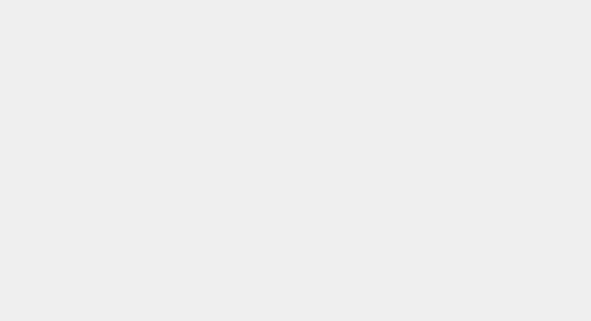
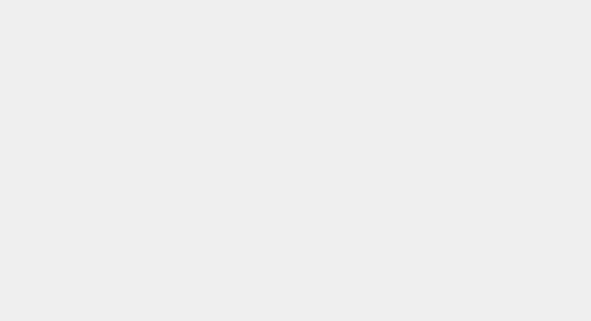
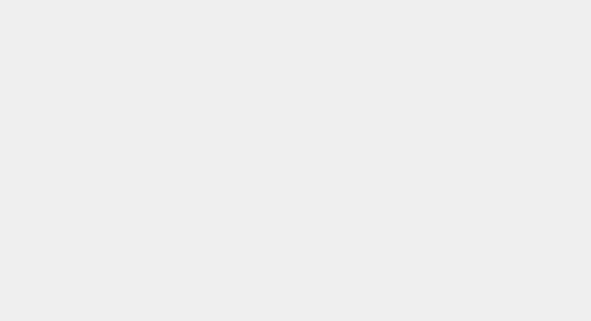
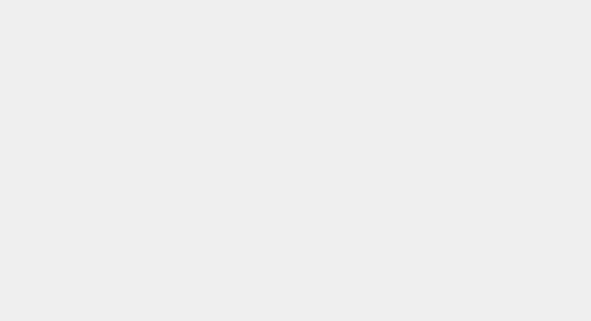
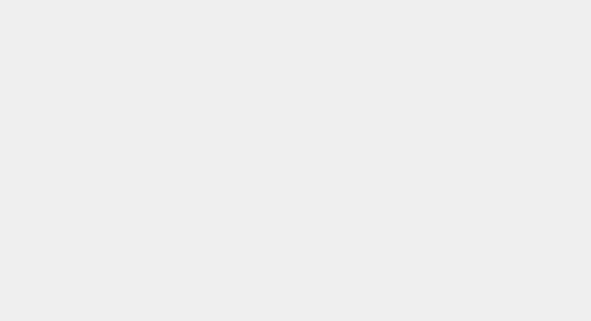
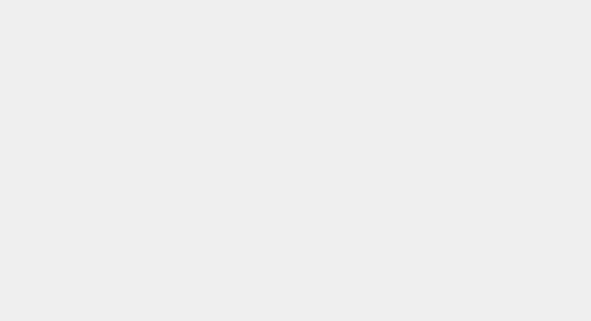
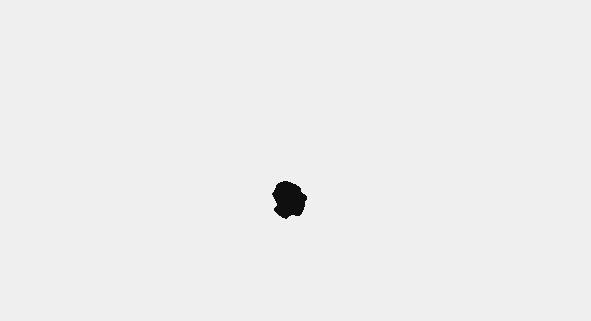
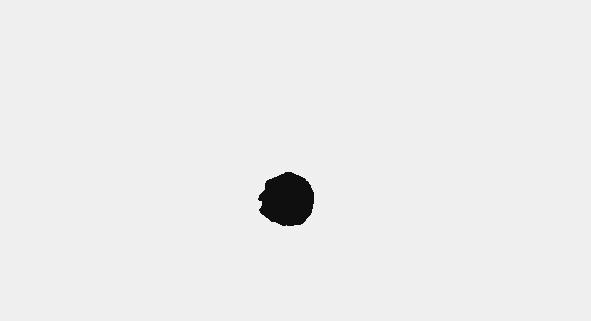
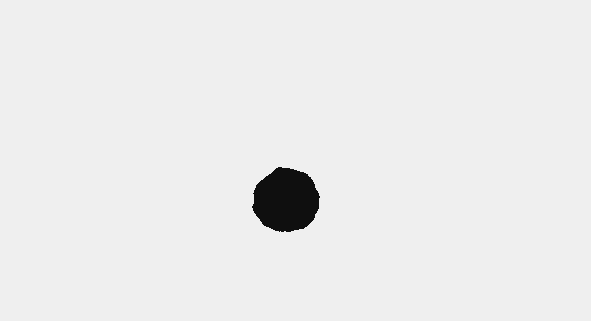
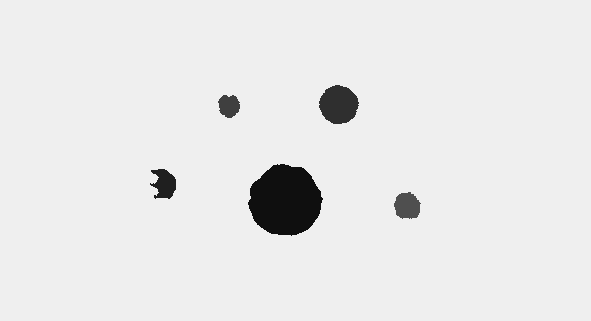
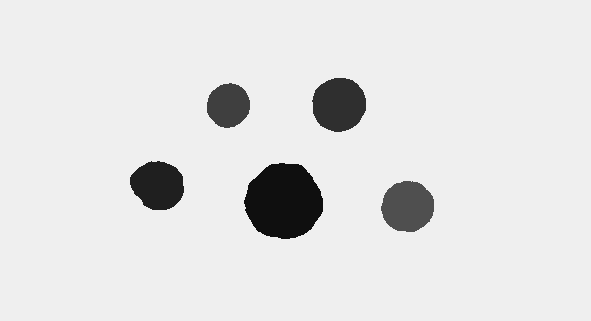
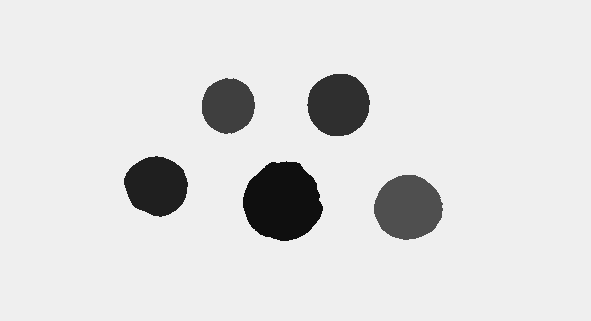
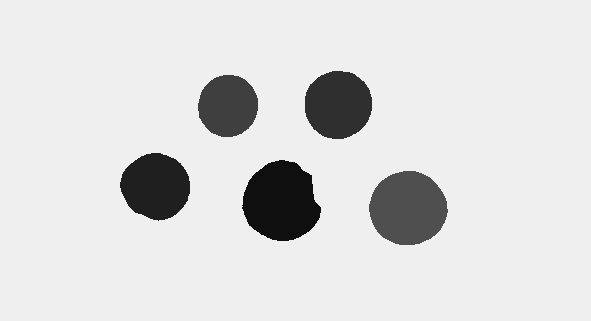
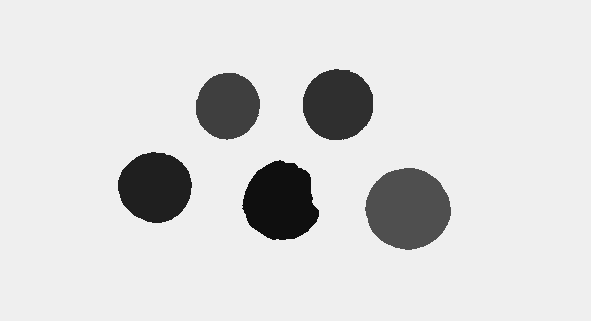
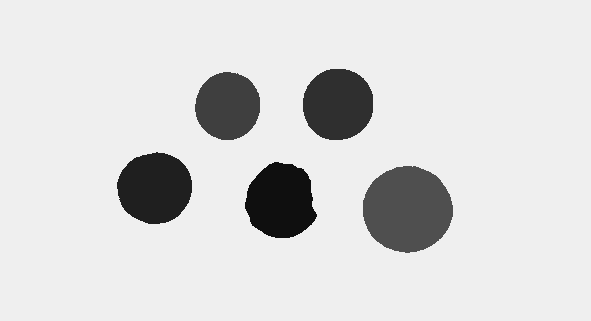
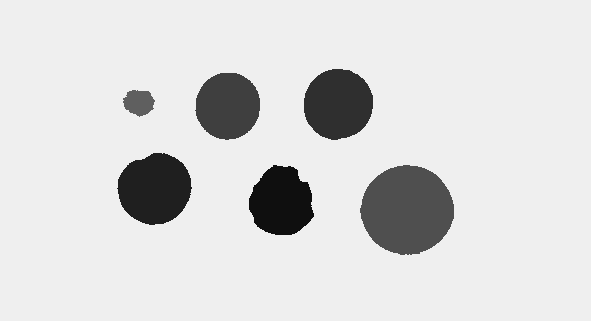
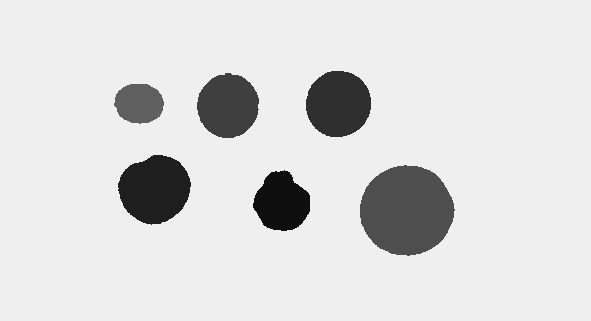
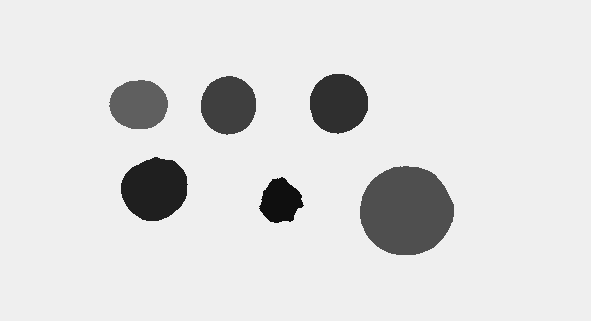
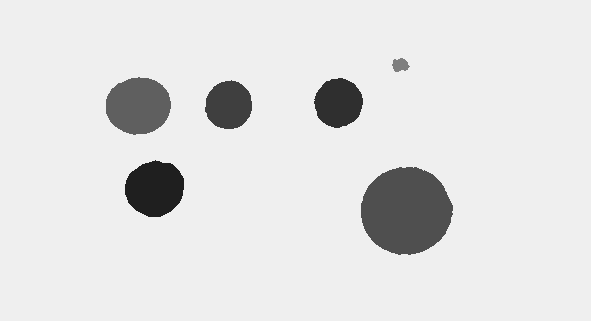
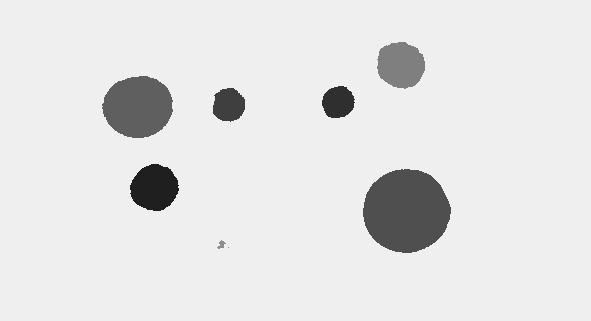
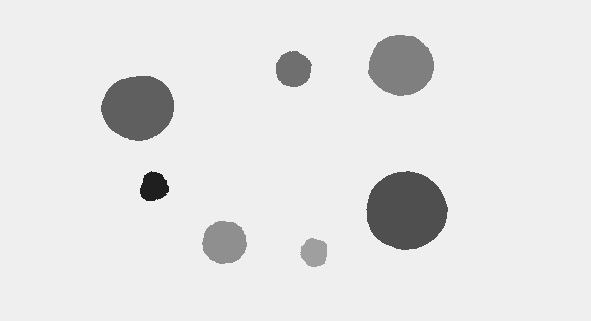
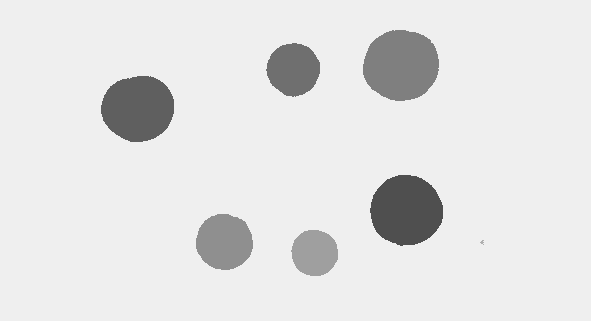
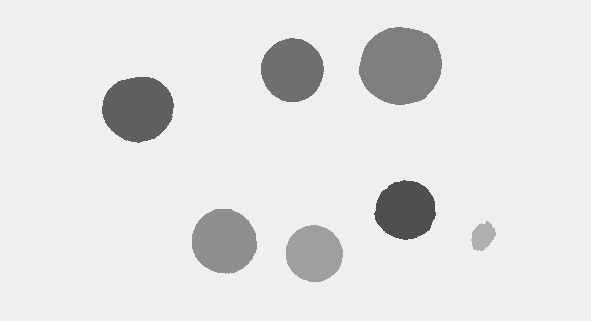
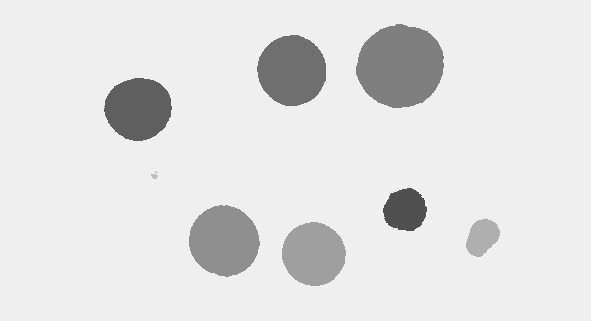
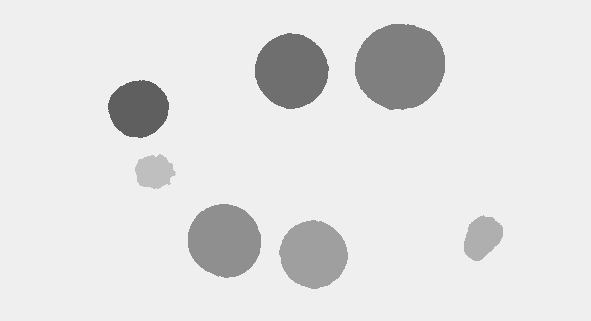
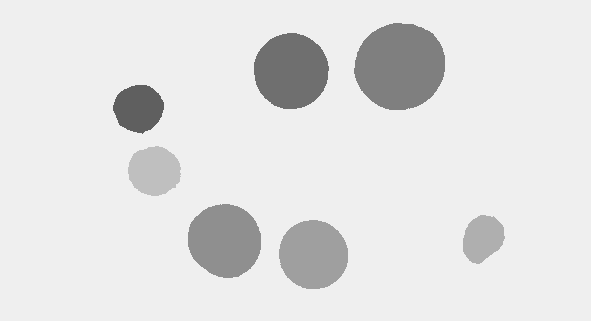
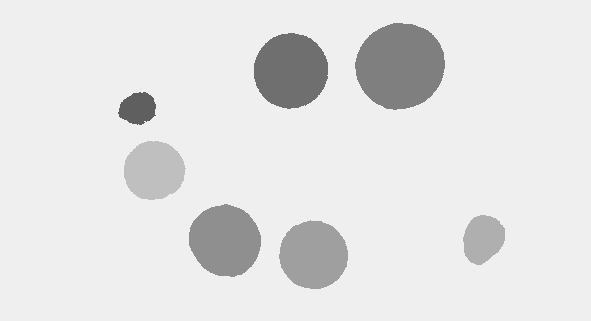
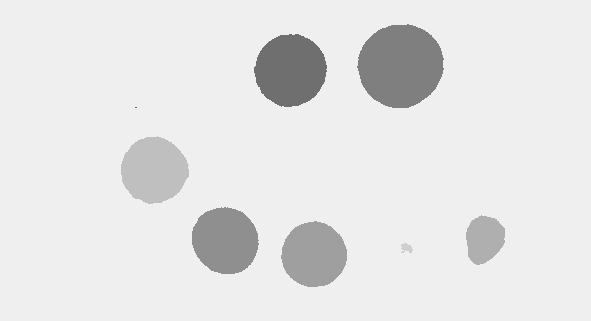
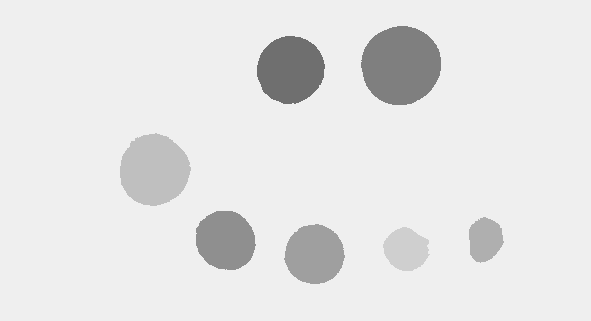
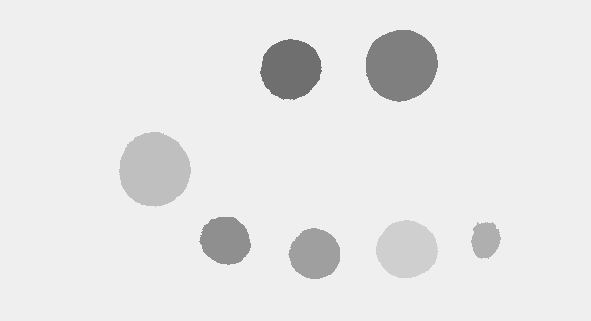
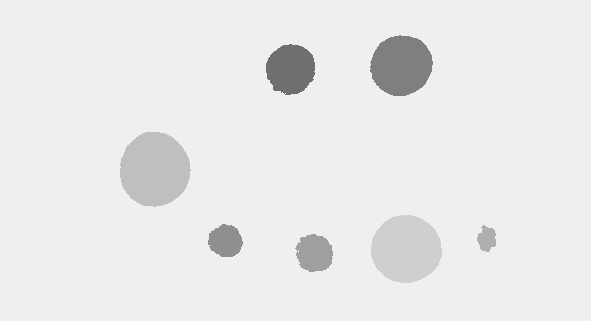
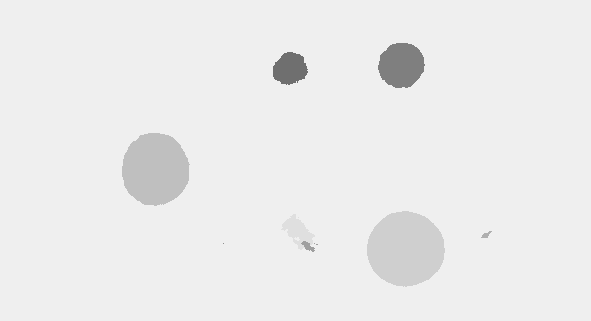
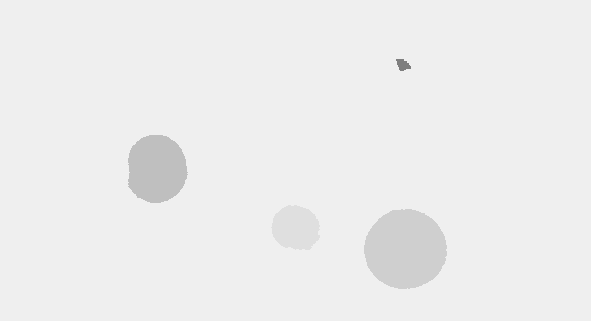
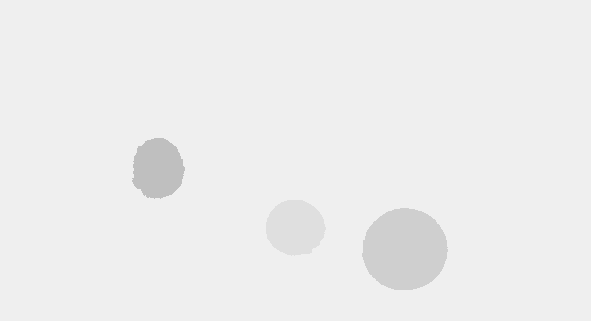
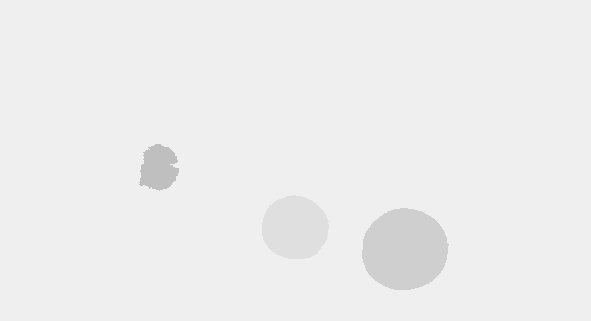
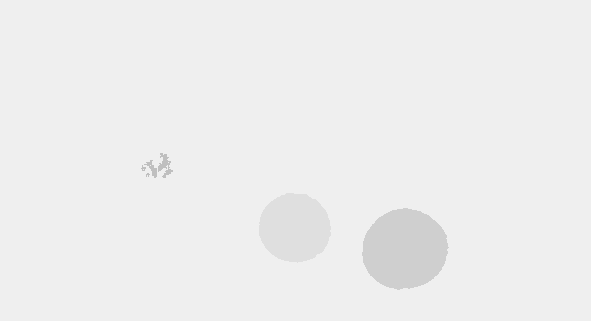
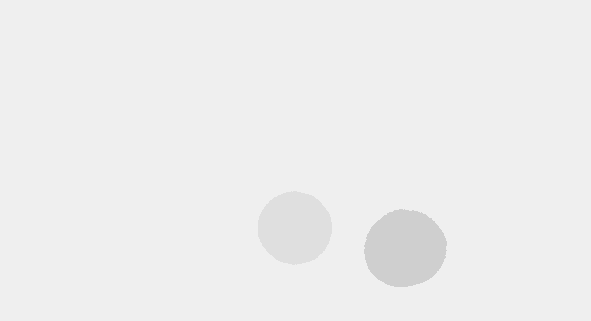
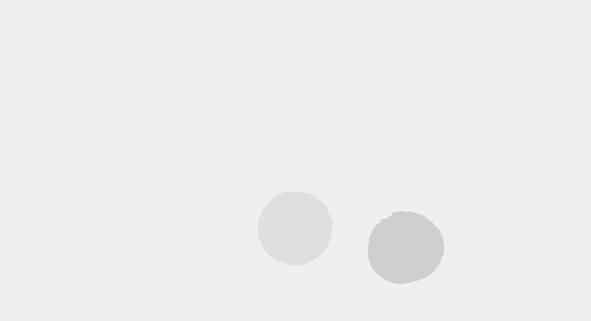
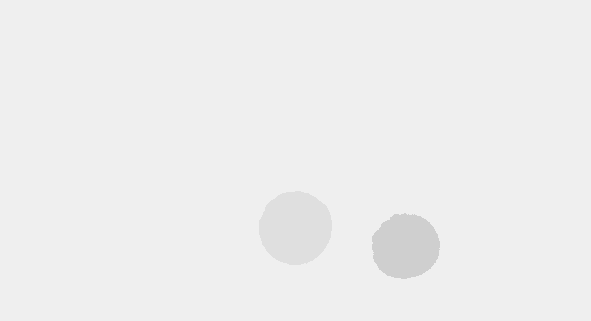
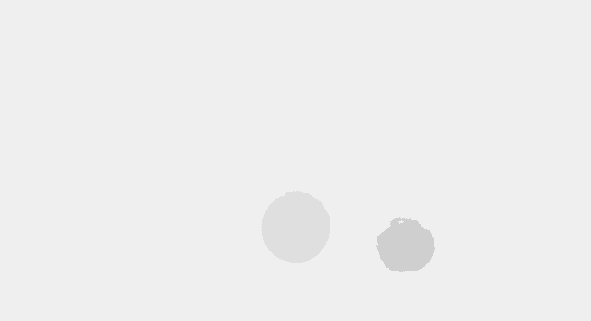
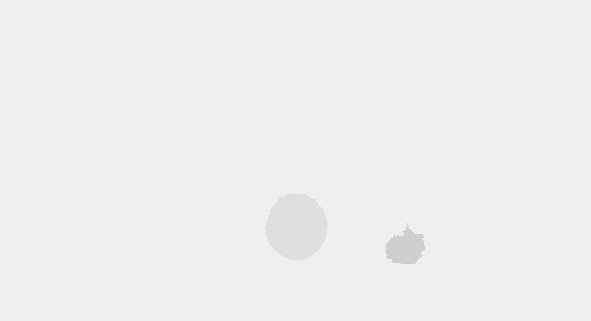
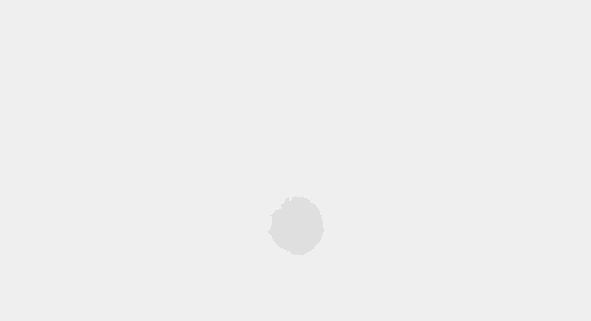
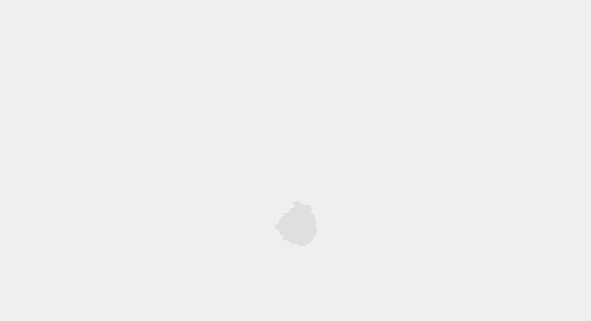
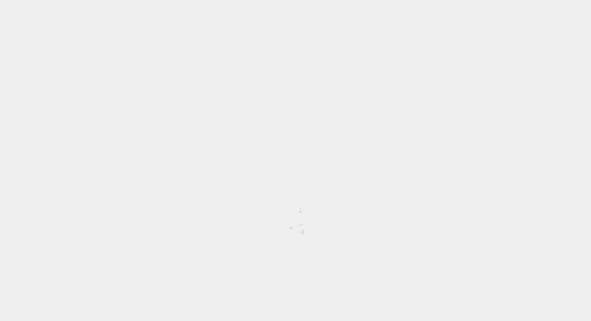
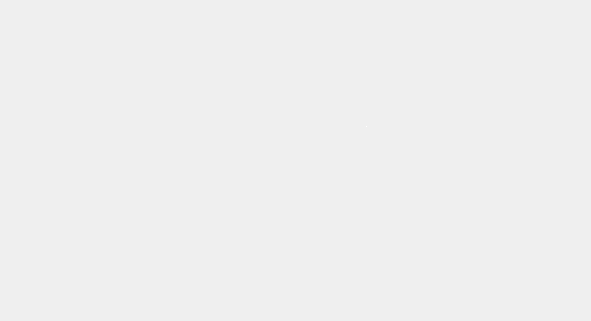
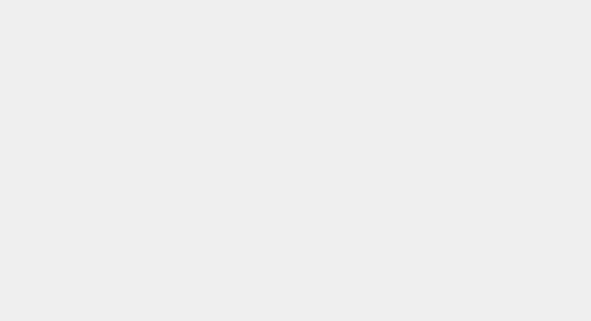
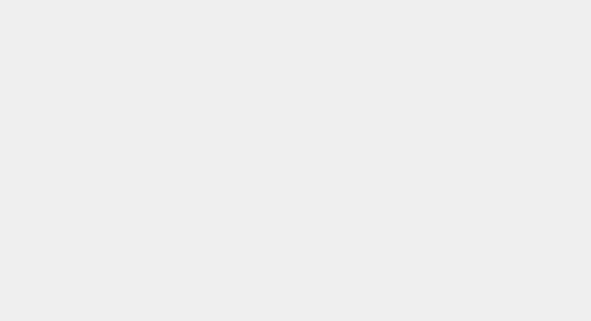
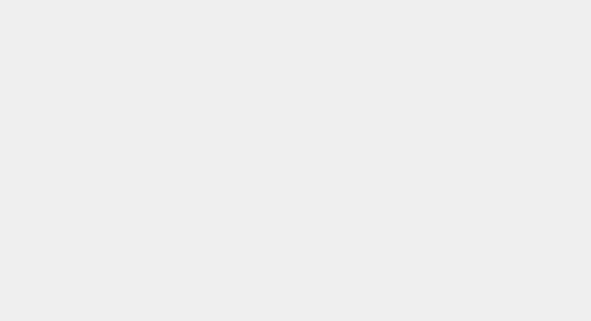
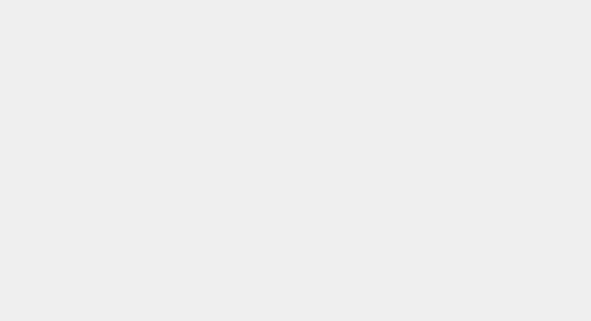
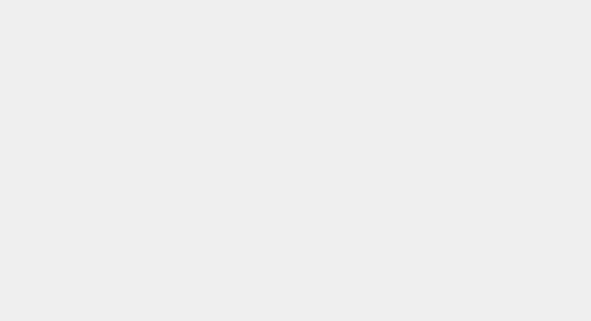
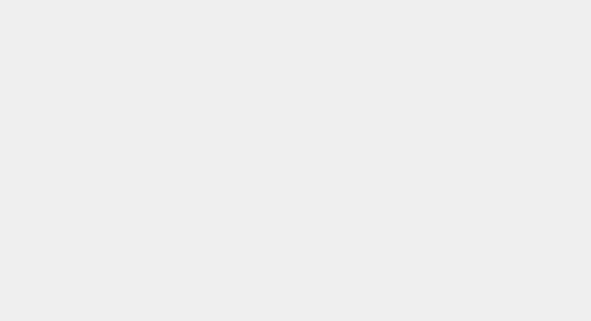
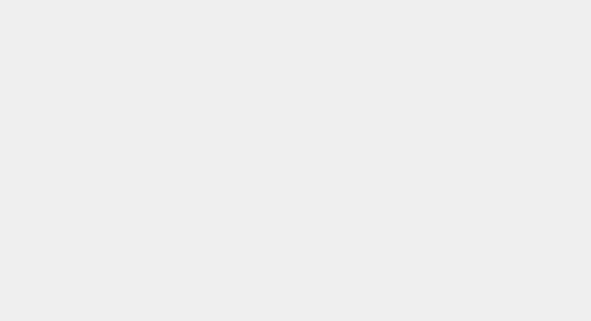

In [ ]:
# Check results - with my seed selection, the last two nuclei are missing - those are the 0 and 1 in above list
vmin, vmax = 0, 16
fskip = 2
fig = px.imshow(
    labels.transpose([2,0,1])[::fskip,:,:], # Requires [z,y,x format]
    zmin=vmin,
    zmax=vmax,
    animation_frame=0,
    binary_string=True,
    color_continuous_scale=px.colors.sequential.Rainbow, # Not working?
    labels={'animation_frame': 'plane'}
)
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
plotly.io.show(fig)

**Something to think about** - When I did this, and often when I do this for other images, the nuclei in the last few z-slices fail in the segmentation. Considering how these images are acquired (live imaging, confocal fluorescence microscopy) and the physics of microscopy, why does the algorithm tend to fail most often on the last few nuclei?

In [ ]:
# Get measurements of nucleus size in physical units (i.e. not pixels), and determine which is the oocyte
rawPixelCounts = [np.sum(labels==i) for i in range(17)] # The huge number corresponds to the background
pixelCounts = [value for value in rawPixelCounts if value != max(rawPixelCounts)] # Remove the background entry in the list
voxelVols = dx**2 * dz # Volume per voxel
nucVols = voxelVols*np.array(pixelCounts)
nucVols = nucVols[nucVols>0.1*np.mean(nucVols)] # Ignore failed results (they're tiny compared to successful ones)
print(nucVols)

[ 8501.362212  6915.826484  6394.814384  5307.169224 13924.346464
  6387.97124   7577.848824 12009.71772   6804.78092   5885.10384
  2000.479096  6844.906628 10508.995504  7360.52716 ]


In [ ]:
# For fun - make an image with nuclei color-coded linearly by volume. This is messy, since watershed outputs don't 
    # match the order of marker numbers. Try regionprops again: those include a list of pixels
props = measure.regionprops(labels) # This works in 3D as well, at least for these properties
count = 1
outIm = np.zeros(img4.shape)
for prop in props:
    pCount = prop.area
    if pCount == max(rawPixelCounts):
      continue
    vol = prop.area*voxelVols
    coords = prop.coords
    for i in range(len(coords)):
        outIm[coords[i][0],coords[i][1],coords[i][2]] = vol
    count += 1

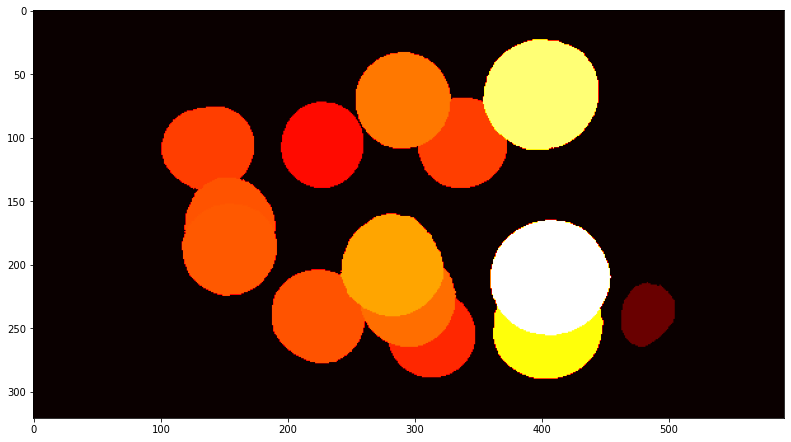

In [ ]:
plt.imshow(np.max(outIm,2), cmap='hot')
plt.gcf().set_size_inches(15, 7.5)
plt.show()
# If you want, find a way to save this as a tif/tiff and view it in FIJI

Notice any trend in nucleus size (hint: remember the layers from the egg chamber schematic)? Is the oocyte nucleus (which is much smaller than the nurse cell nuclei) obvious? If it isn't, something likely went wrong.

### FIJI's version

This process is easier in FIJI. Now that you understand how it works, try it out if you want to see if it's better or faster than the Python version above.
- Preprocessing: background subtraction using the rolling-ball method is under 'Process > Subtract background', and 'Process > Filters' provides several options for blurring.
- Watershed algorithm: 'Plugins > MorphoLibJ > Segmentation > Interactive Marker-controlled Watershed' is essentially what you did earlier, but more user-friendly.

## If you've finished all of the examples...
Good job!

Also, we have a lot of images you can try to segment using the above methods (or any others of your choice). Let one of us know if you'd like to explore with these images.